In [1]:
!pip install mne

# Ghichimichi plot

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3172936621.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3172936621.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3172936621.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3172936621.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3172936621.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3172936621.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

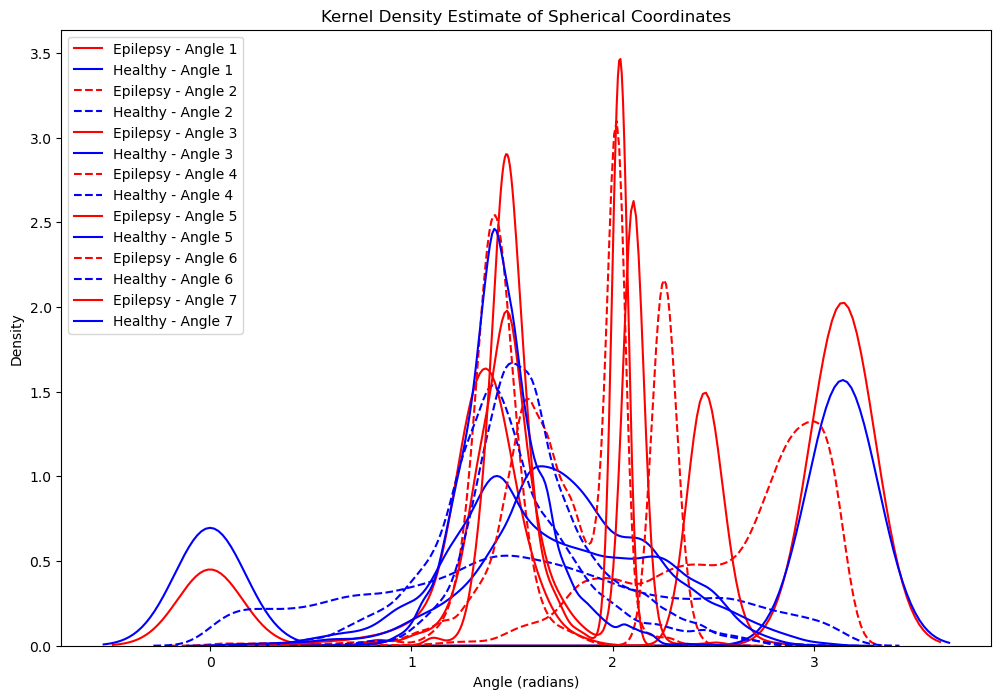

In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random files from each folder
    epilepsy_file = random.choice([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')])
    healthy_file = random.choice([f for f in os.listdir(healthy_folder) if f.endswith('.fif')])

    epilepsy_angles = process_file(os.path.join(epilepsy_folder, epilepsy_file))
    healthy_angles = process_file(os.path.join(healthy_folder, healthy_file))

    epilepsy_angles = np.array(epilepsy_angles)
    healthy_angles = np.array(healthy_angles)

    plt.figure(figsize=(12, 8))

    for i in range(7):
        sns.kdeplot(epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r', linestyle='-' if i % 2 == 0 else '--')
        sns.kdeplot(healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b', linestyle='-' if i % 2 == 0 else '--')

    plt.xlabel('Angle (radians)')
    plt.ylabel('Density')
    plt.title('Kernel Density Estimate of Spherical Coordinates')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Plot for one random sample each

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/554726486.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/554726486.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/554726486.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/554726486.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/554726486.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/554726486.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638

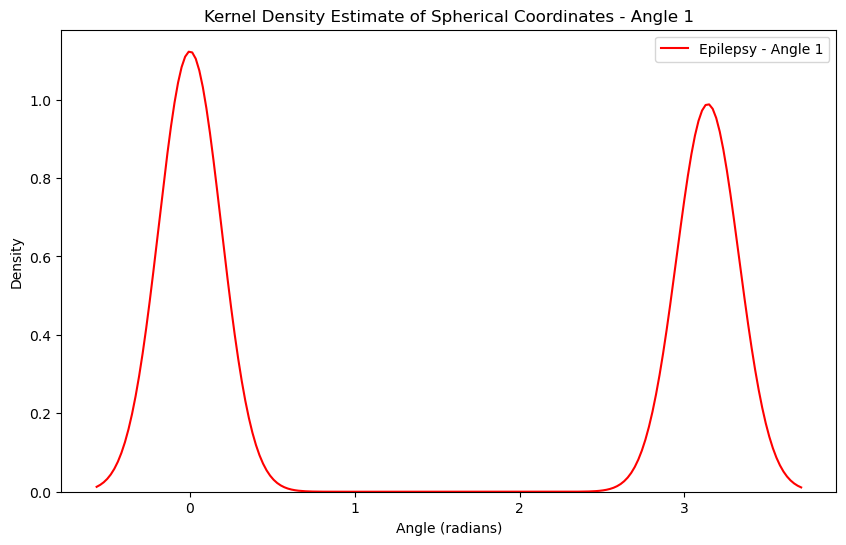

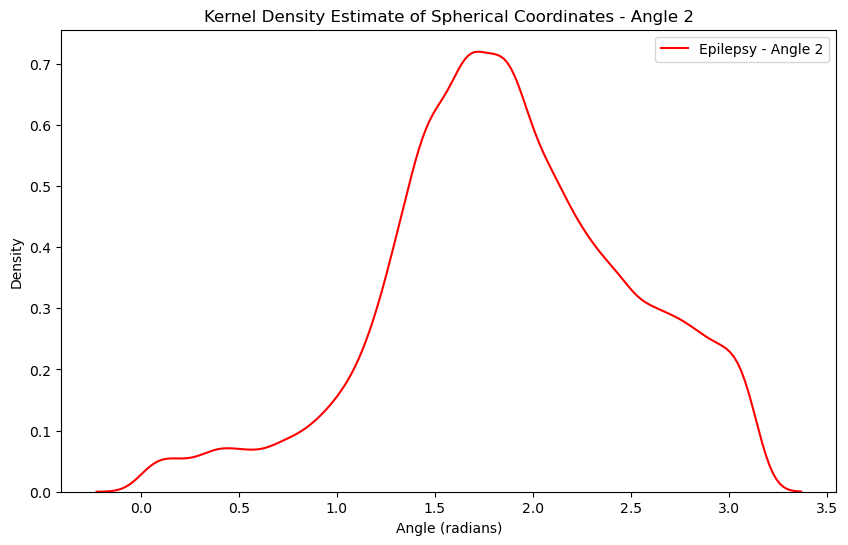

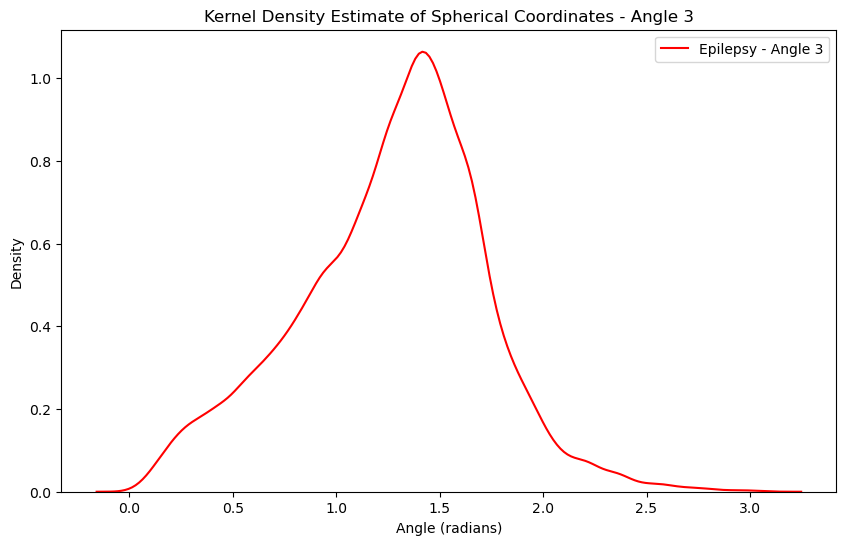

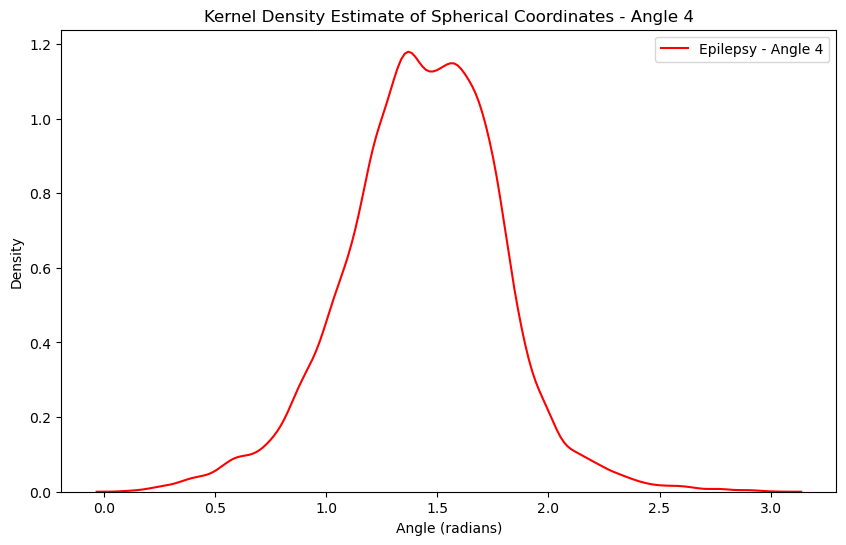

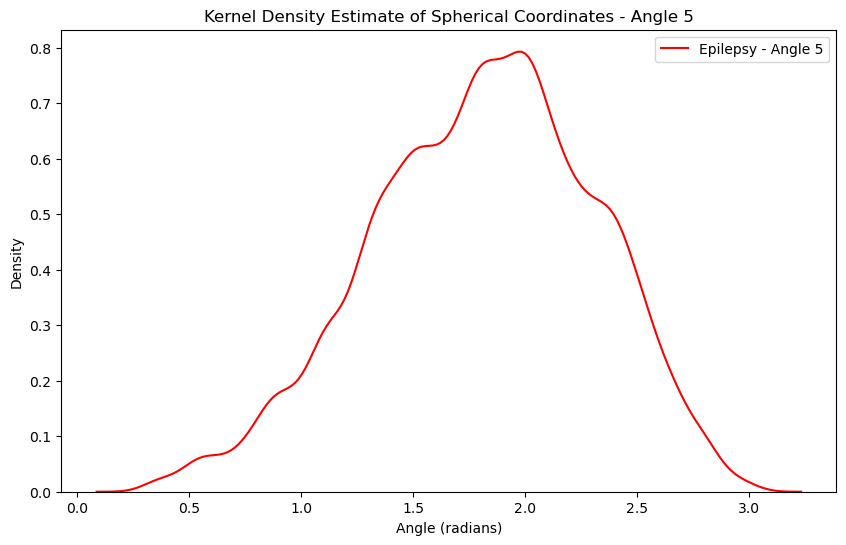

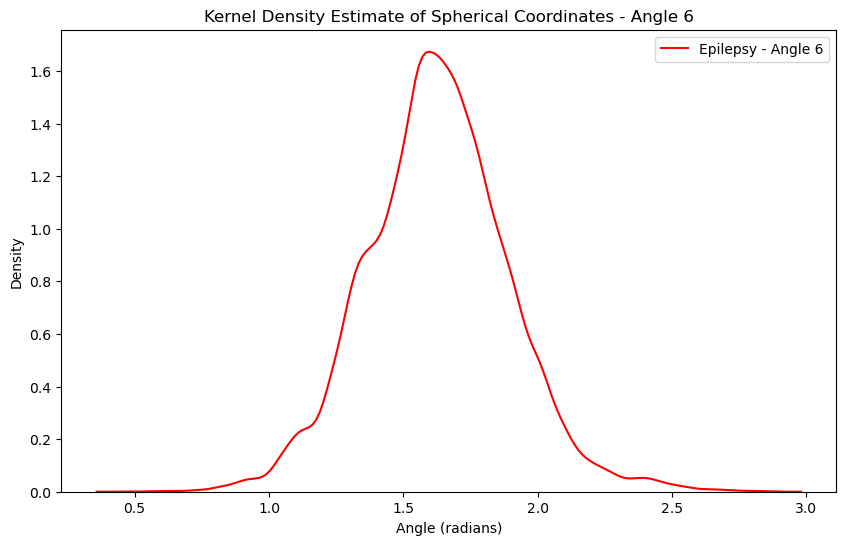

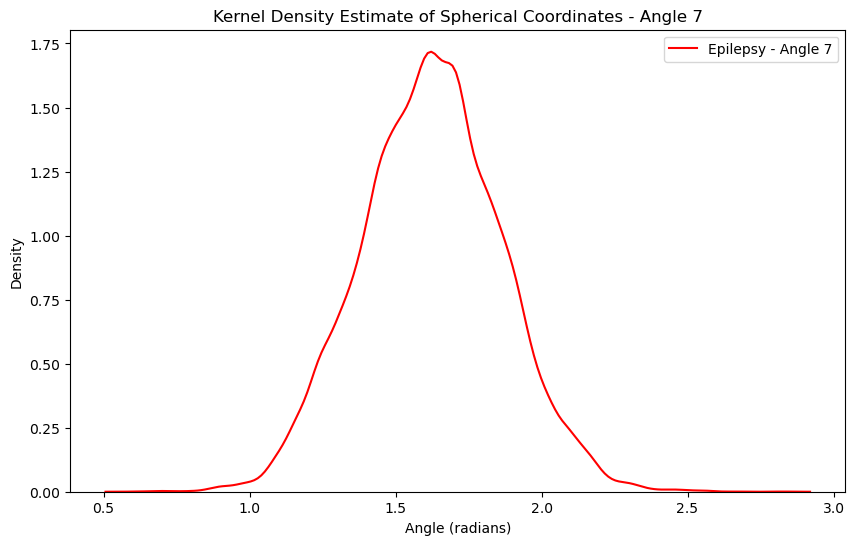

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random files from each folder
    epilepsy_file = random.choice([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')])
    healthy_file = random.choice([f for f in os.listdir(healthy_folder) if f.endswith('.fif')])

    epilepsy_angles = process_file(os.path.join(epilepsy_folder, epilepsy_file))
    healthy_angles = process_file(os.path.join(healthy_folder, healthy_file))

    epilepsy_angles = np.array(epilepsy_angles)
    healthy_angles = np.array(healthy_angles)

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        #sns.kdeplot(healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Feature vector as the sum of right and left vectors

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/104122779.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/104122779.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/104122779.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/104122779.py:18: FutureWarning: The default for pick_channels will ch

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/104122779.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/104122779.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/104122779.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050

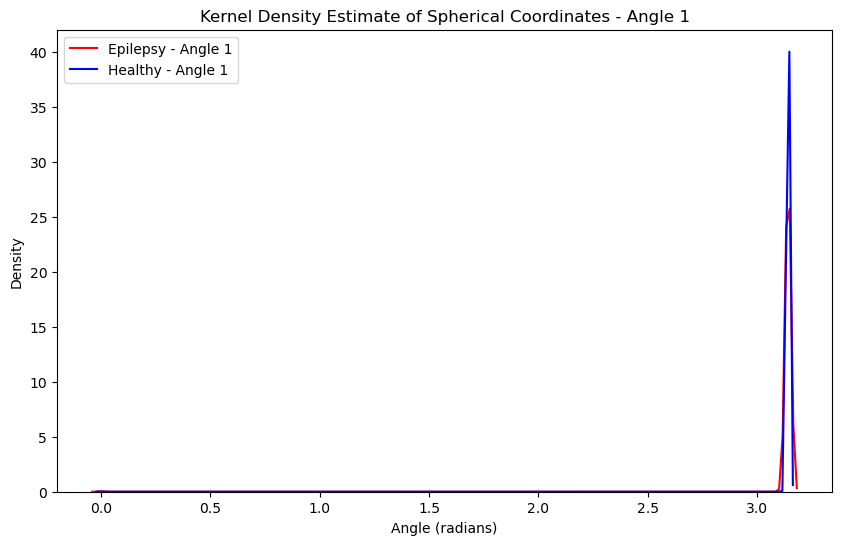

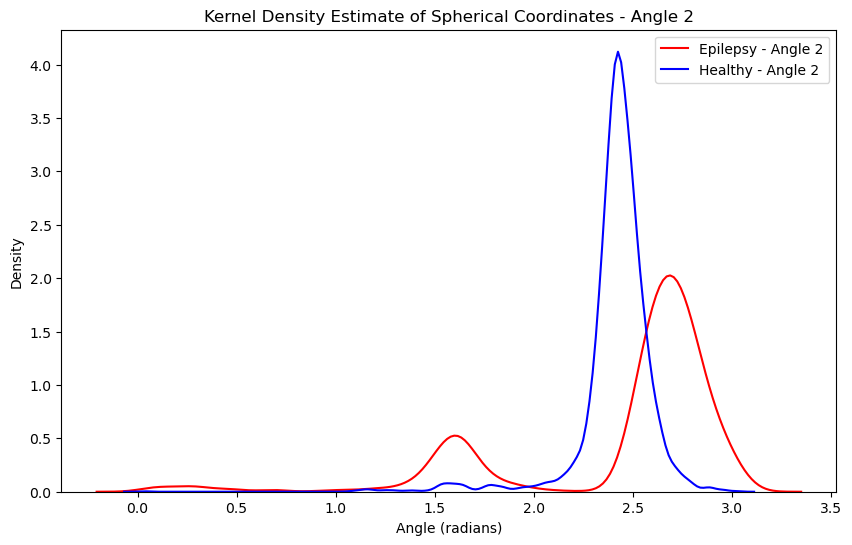

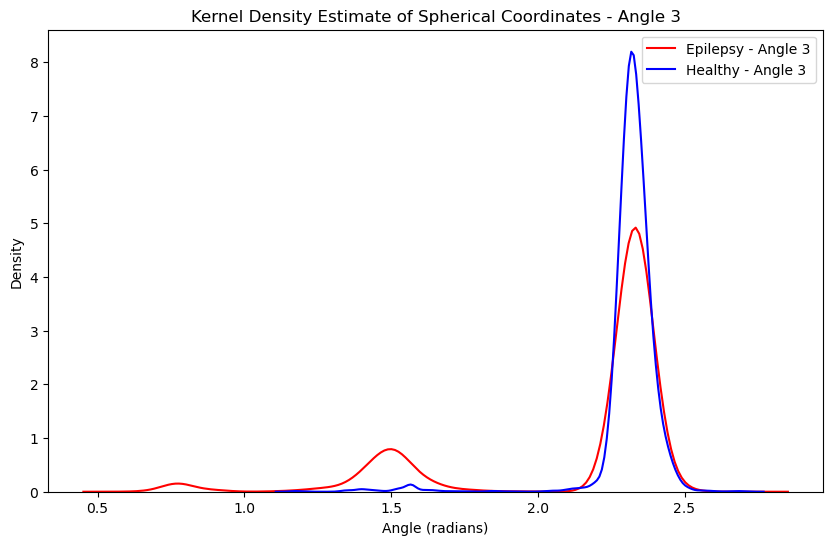

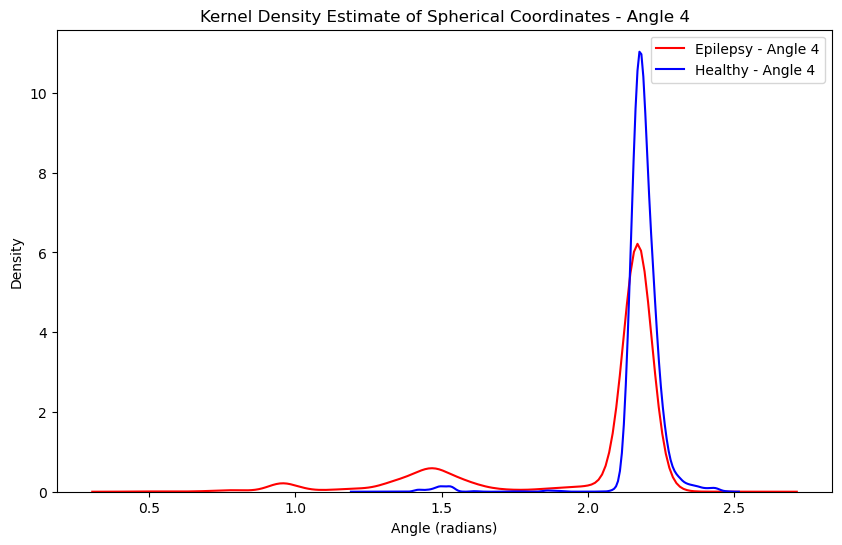

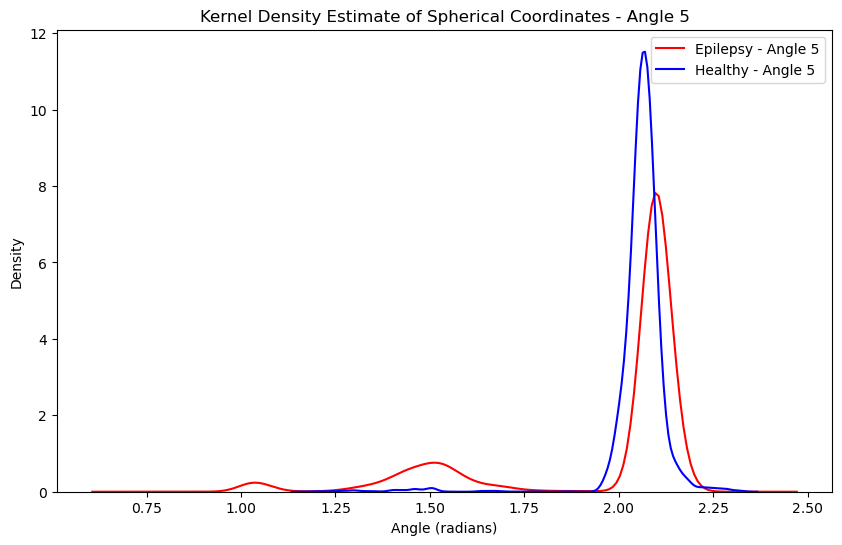

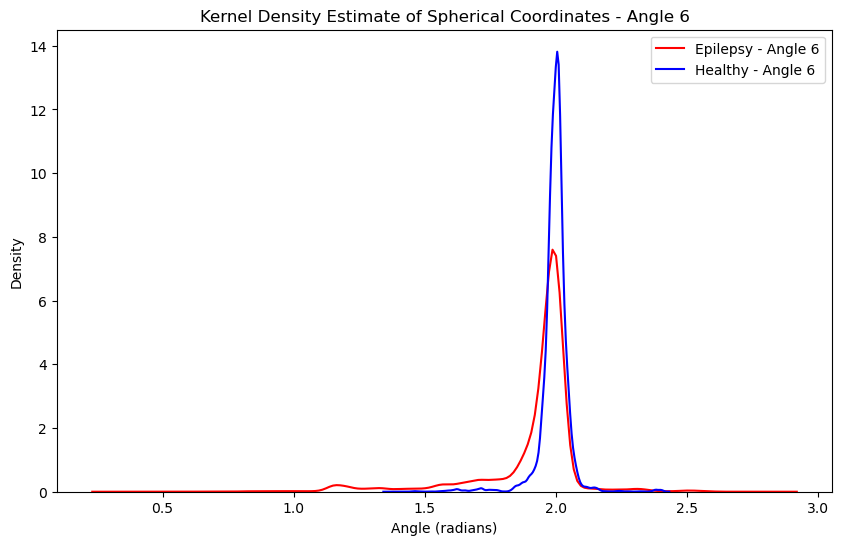

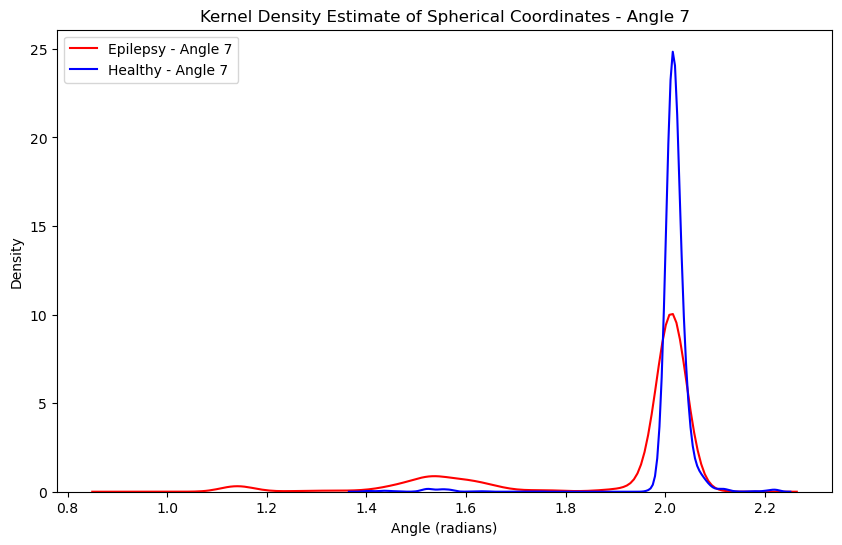

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec + right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random files from each folder
    epilepsy_file = random.choice([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')])
    healthy_file = random.choice([f for f in os.listdir(healthy_folder) if f.endswith('.fif')])

    epilepsy_angles = process_file(os.path.join(epilepsy_folder, epilepsy_file))
    healthy_angles = process_file(os.path.join(healthy_folder, healthy_file))

    epilepsy_angles = np.array(epilepsy_angles)
    healthy_angles = np.array(healthy_angles)

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Woww RO-SEE!

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1376257204.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1376257204.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1376257204.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1376257204.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1376257204.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1376257204.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

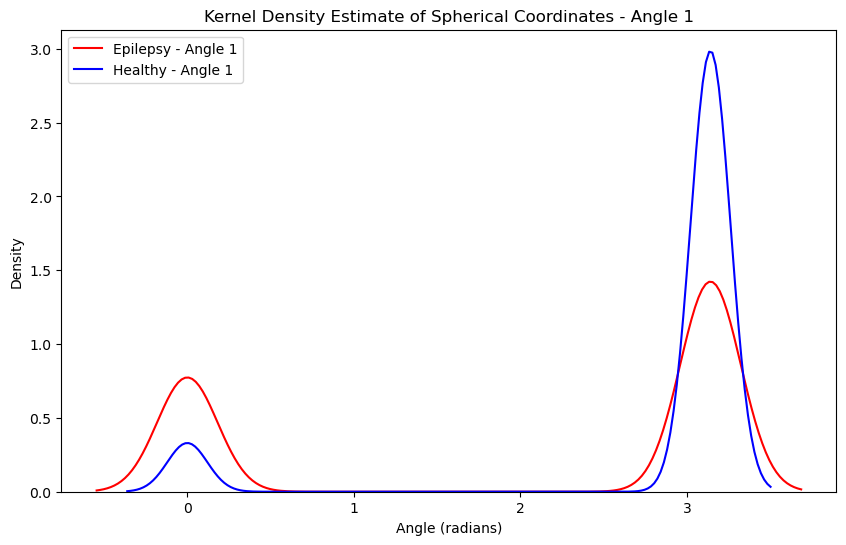

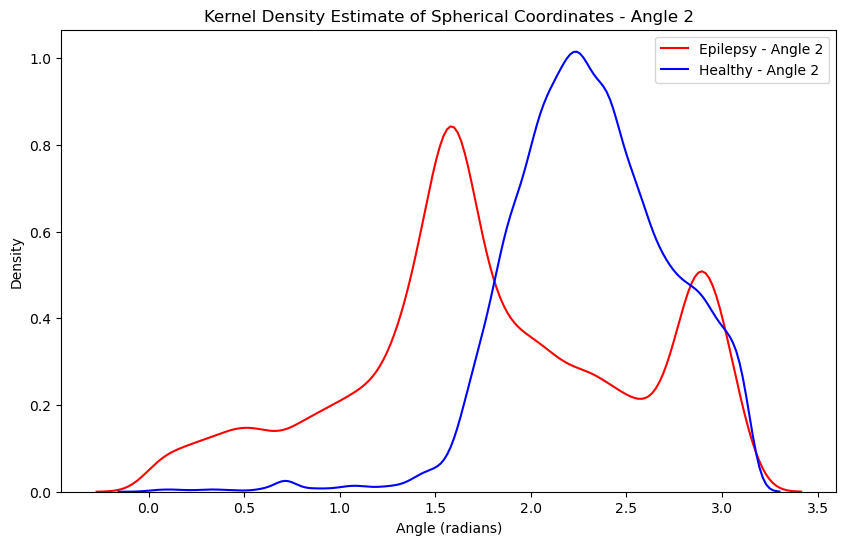

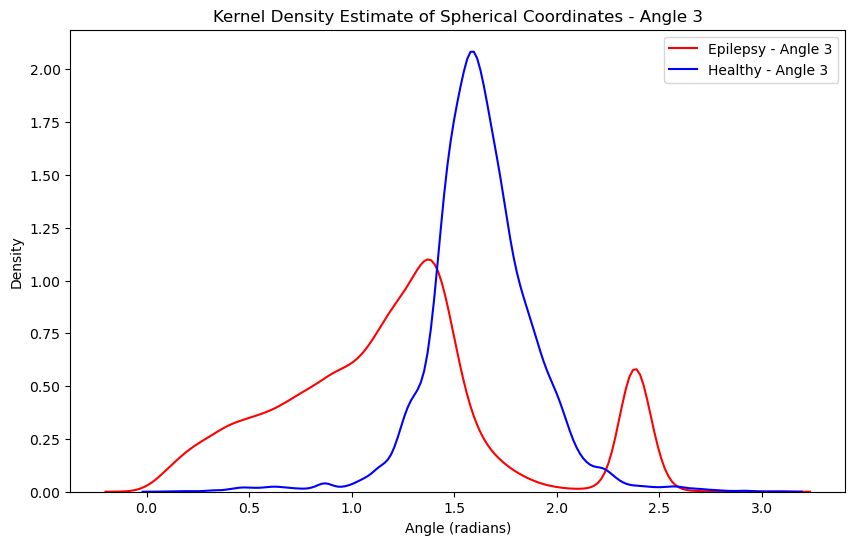

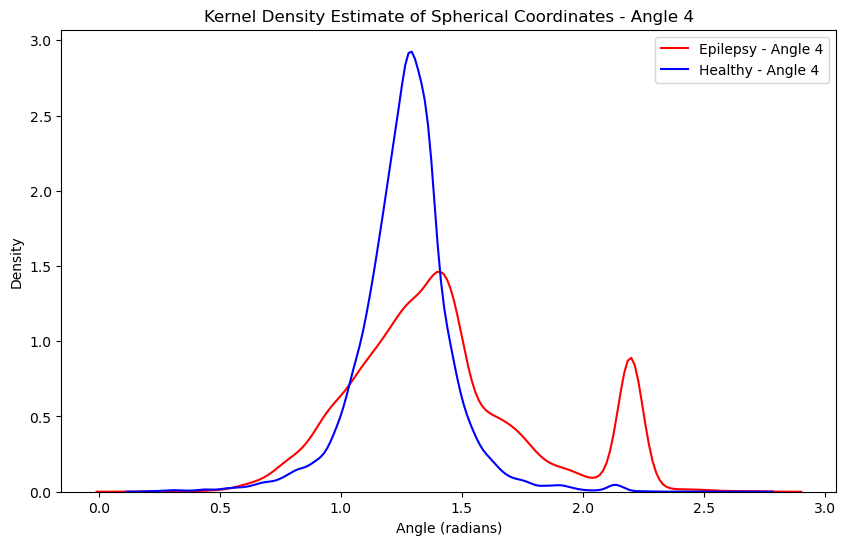

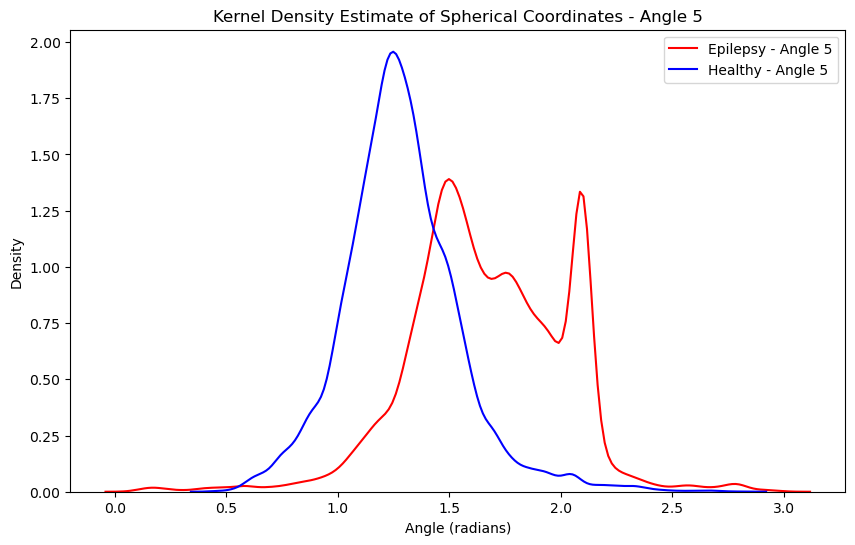

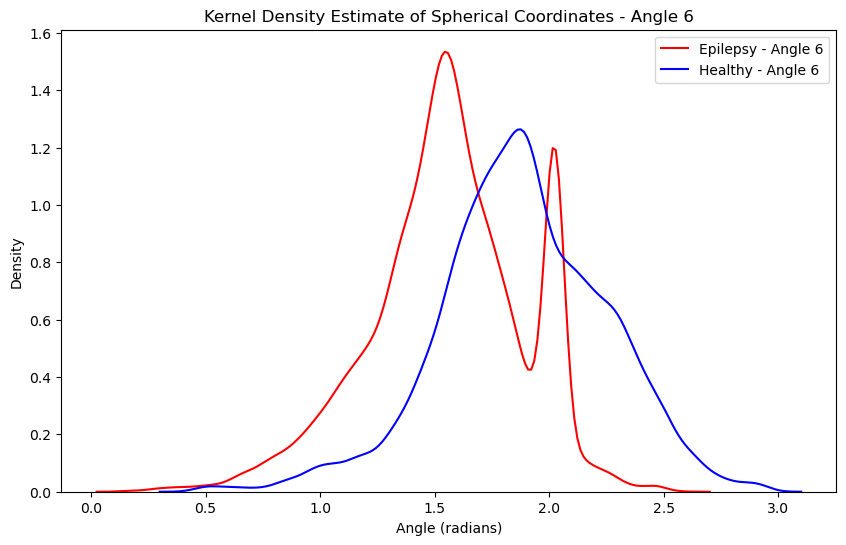

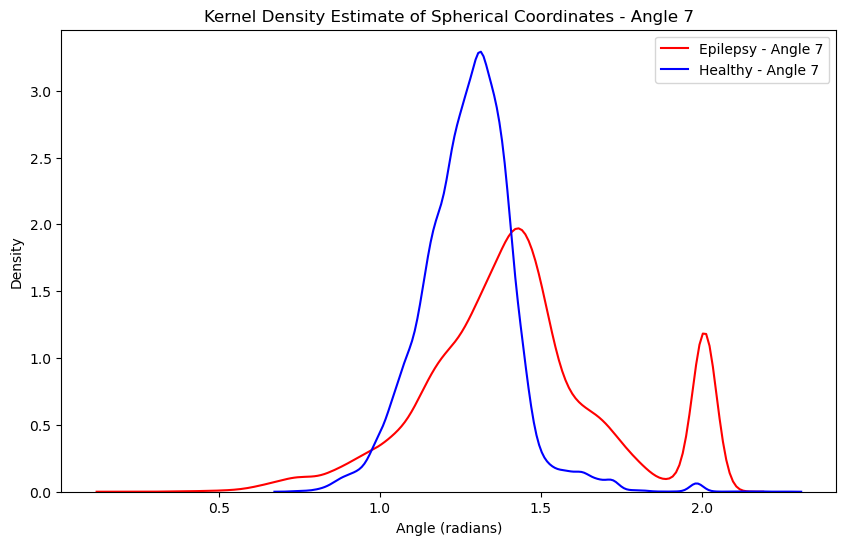

In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random files from each folder
    epilepsy_file = random.choice([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')])
    healthy_file = random.choice([f for f in os.listdir(healthy_folder) if f.endswith('.fif')])

    epilepsy_angles = process_file(os.path.join(epilepsy_folder, epilepsy_file))
    healthy_angles = process_file(os.path.join(healthy_folder, healthy_file))

    epilepsy_angles = np.array(epilepsy_angles)
    healthy_angles = np.array(healthy_angles)

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1758625119.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1758625119.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1758625119.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1758625119.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1758625119.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/1758625119.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

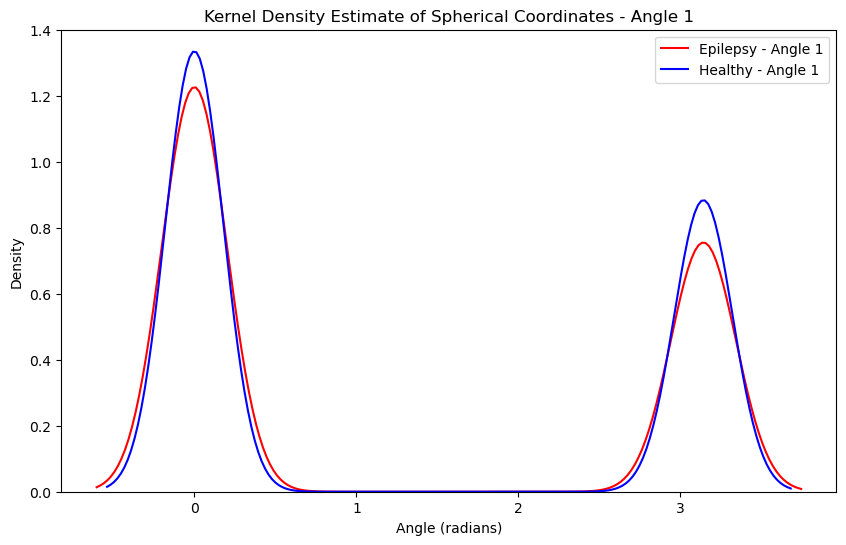

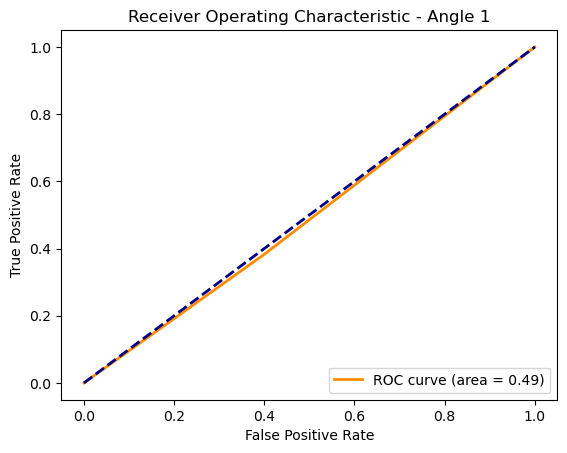

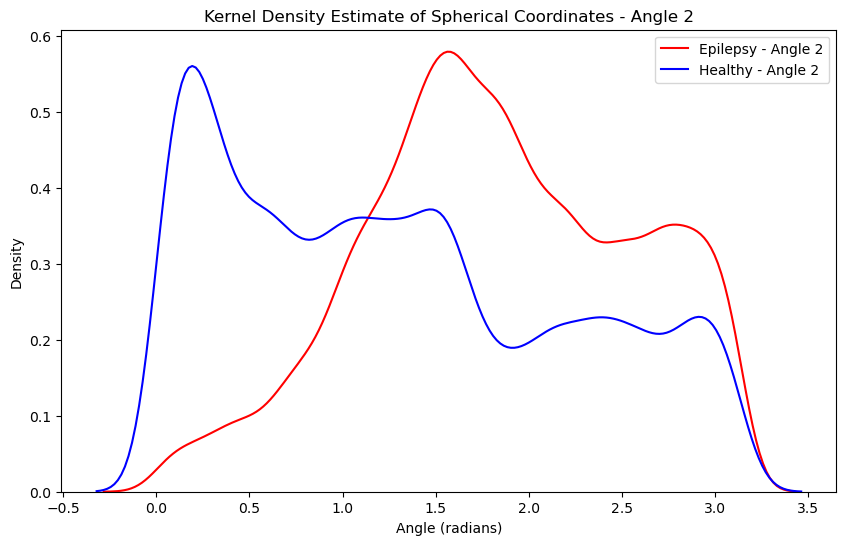

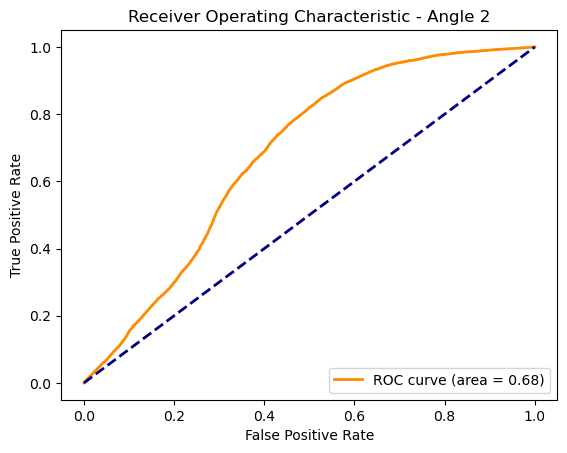

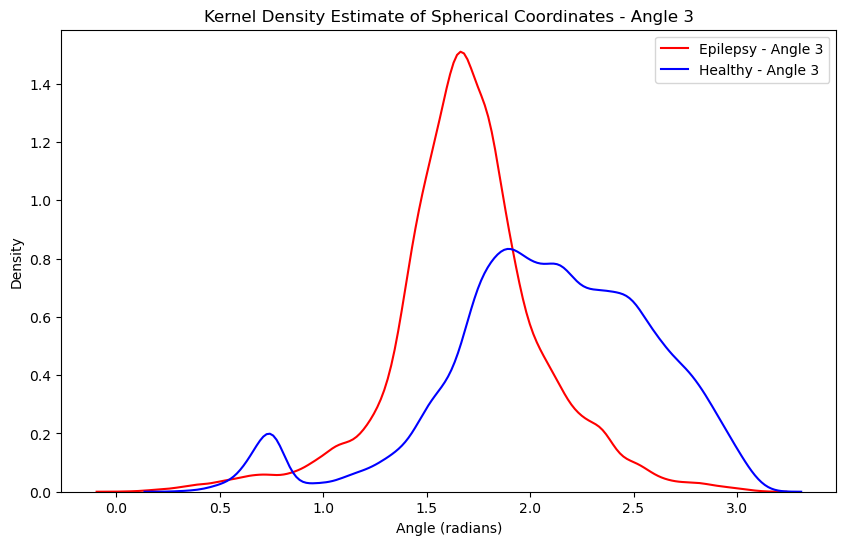

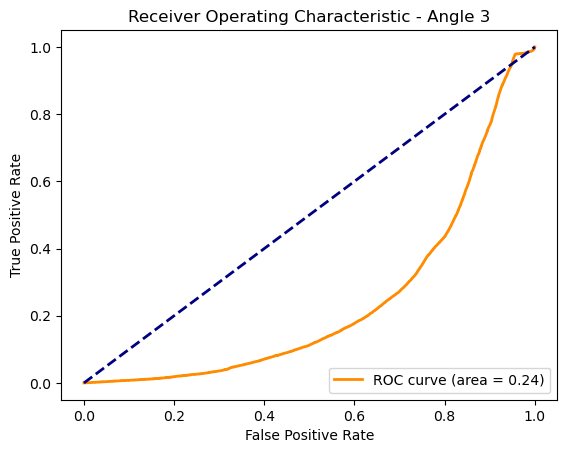

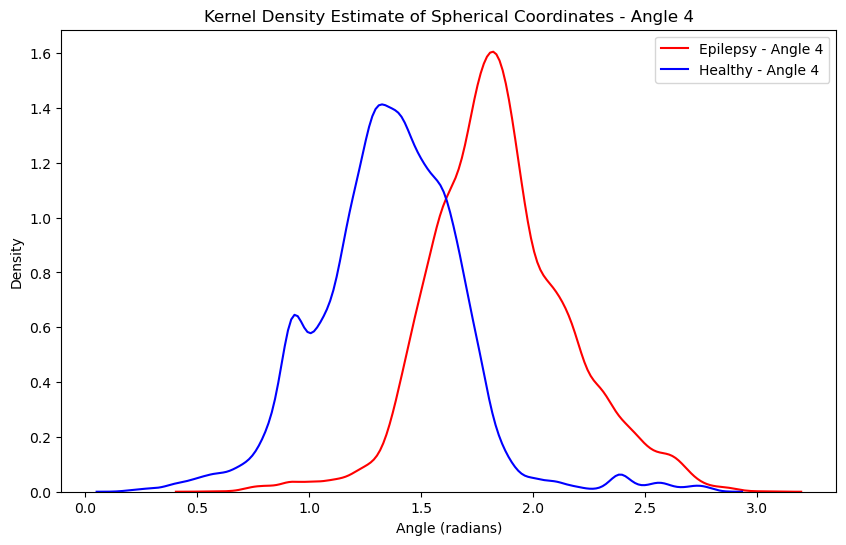

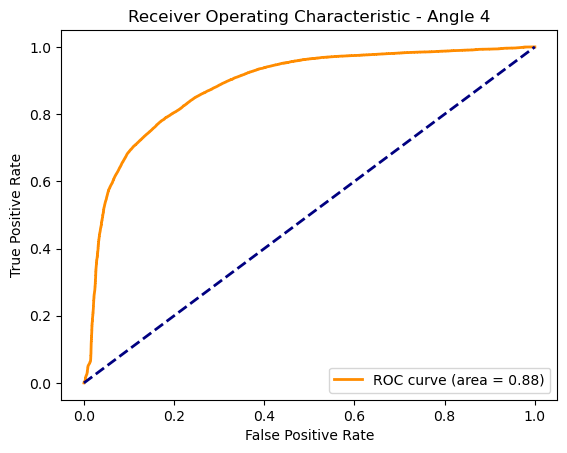

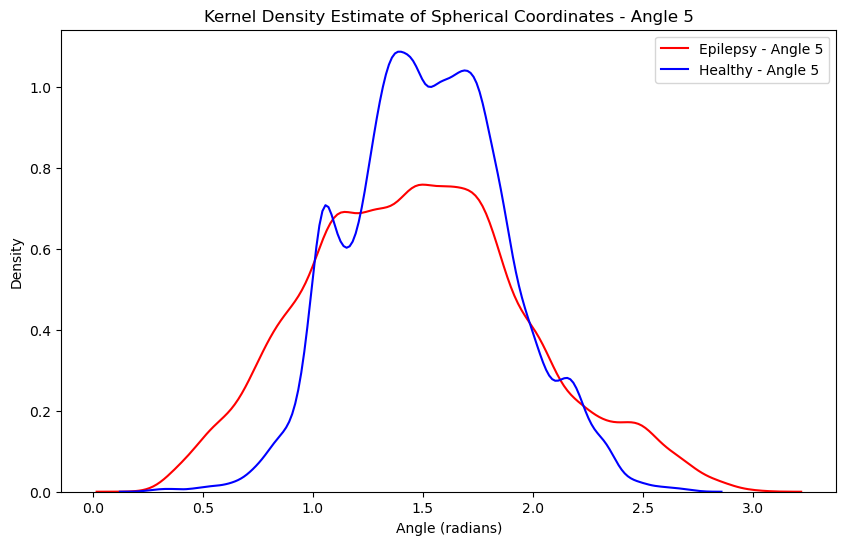

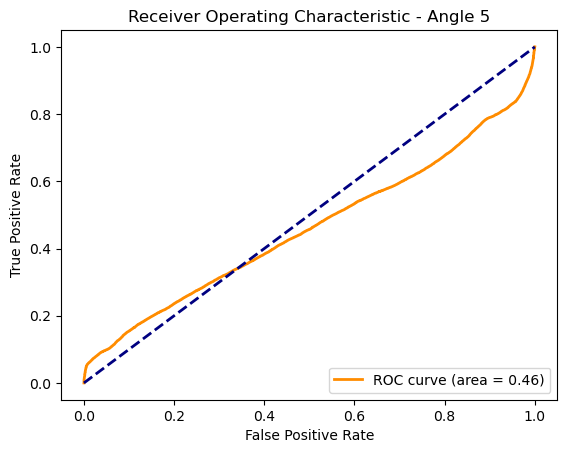

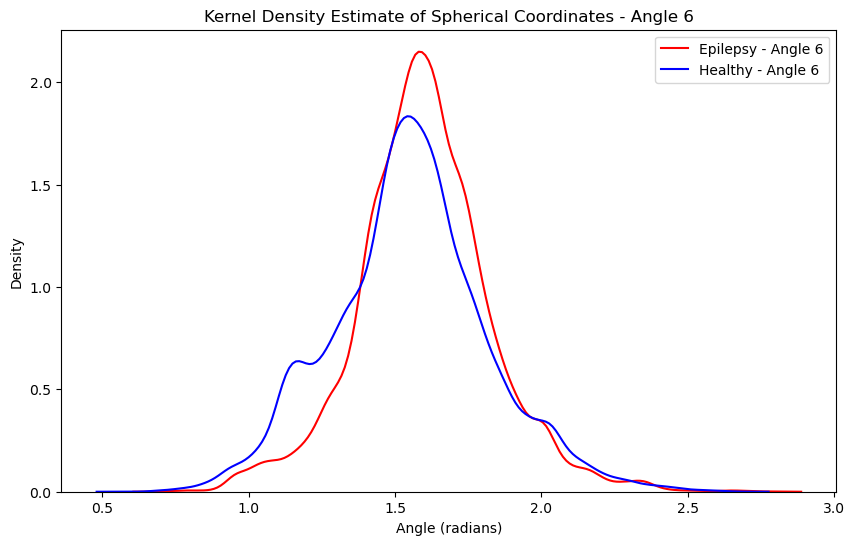

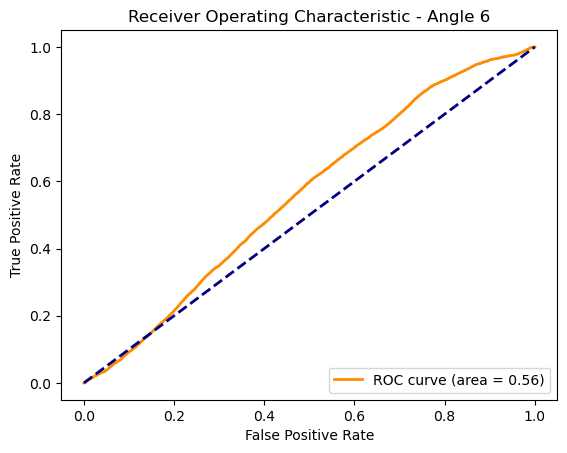

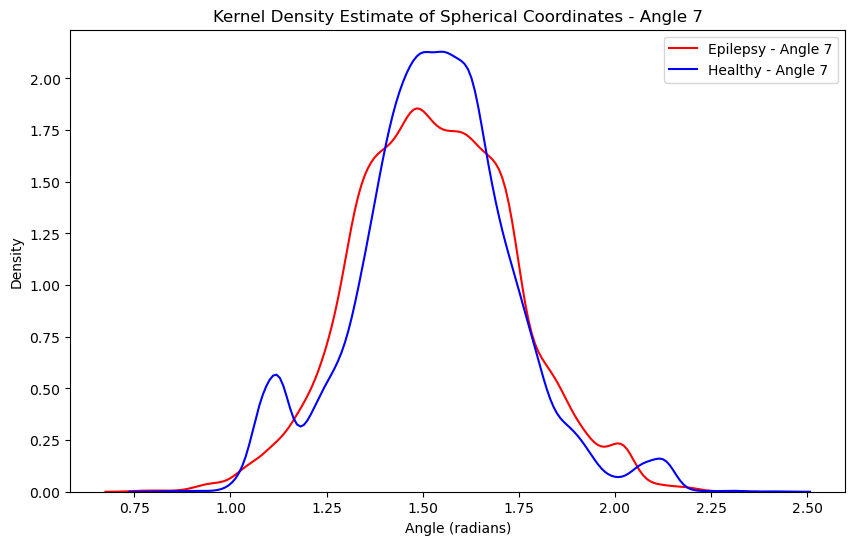

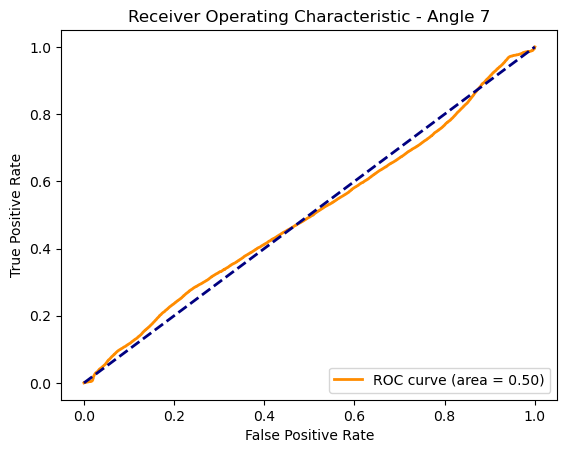

In [5]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random files from each folder
    epilepsy_file = random.choice([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')])
    healthy_file = random.choice([f for f in os.listdir(healthy_folder) if f.endswith('.fif')])

    epilepsy_angles = process_file(os.path.join(epilepsy_folder, epilepsy_file))
    healthy_angles = process_file(os.path.join(healthy_folder, healthy_file))

    # Combine data and create labels
    all_angles = np.vstack((epilepsy_angles, healthy_angles))
    labels = np.array([1] * len(epilepsy_angles) + [0] * len(healthy_angles))  # 1 for epilepsy, 0 for healthy

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, all_angles[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Angle {i+1}')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Added feature vector

# Adding left and right to get feature vectors

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/4291270104.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/4291270104.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/4291270104.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

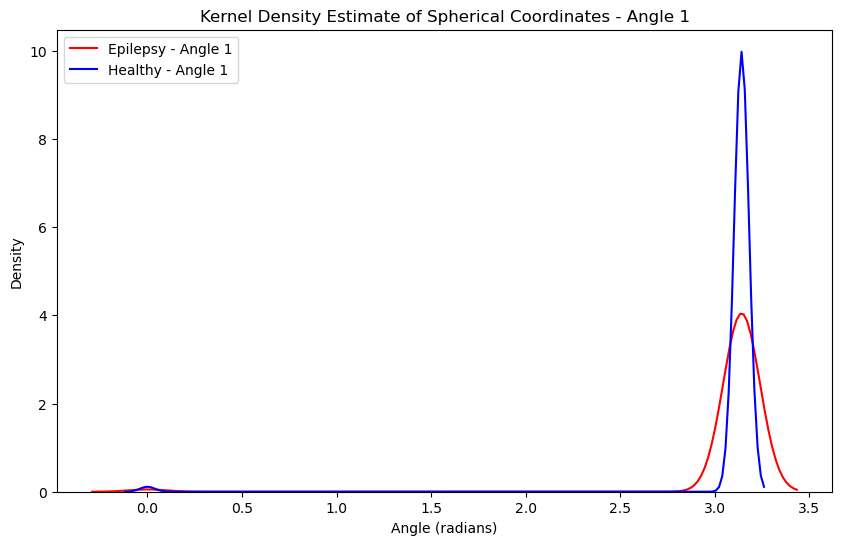

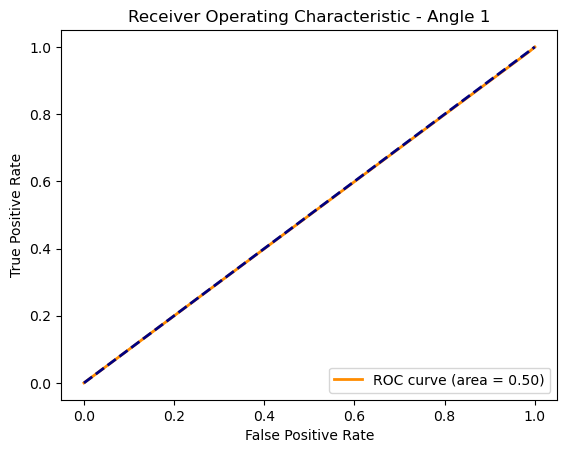

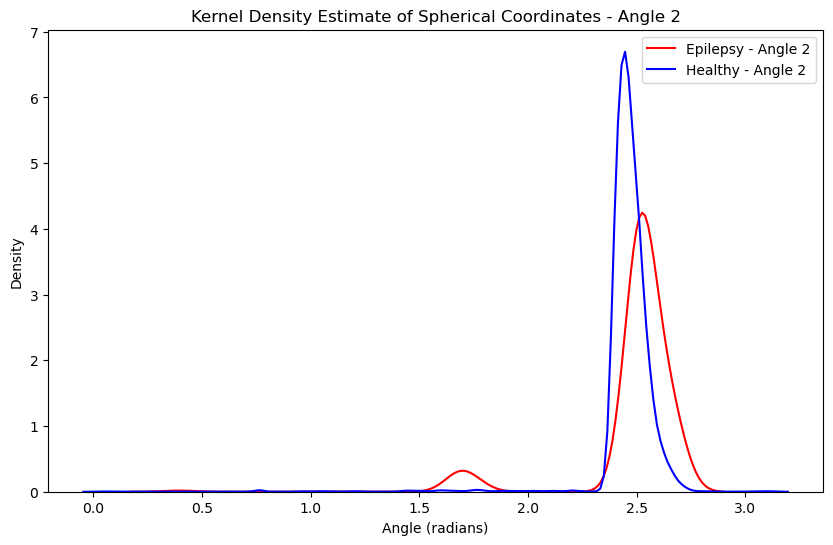

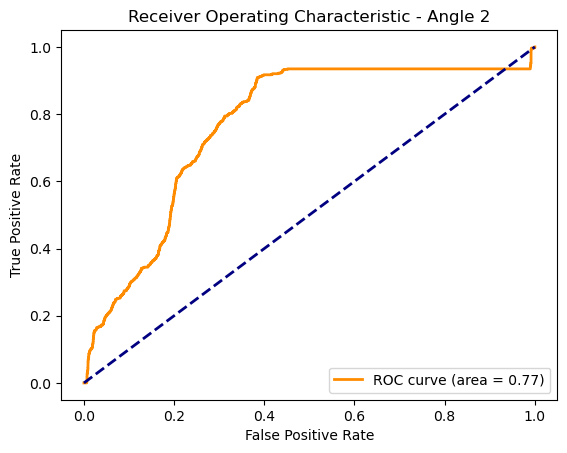

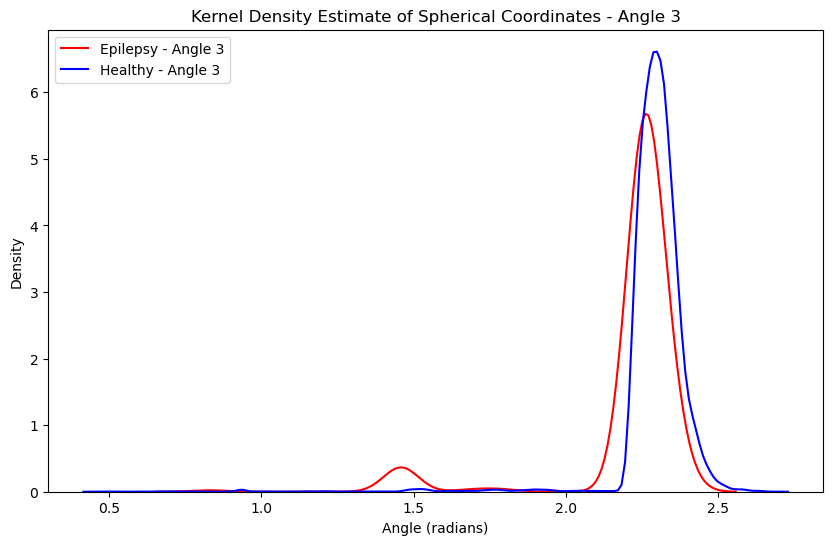

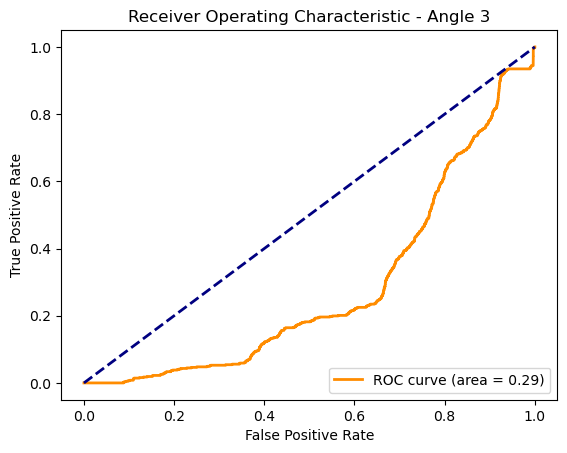

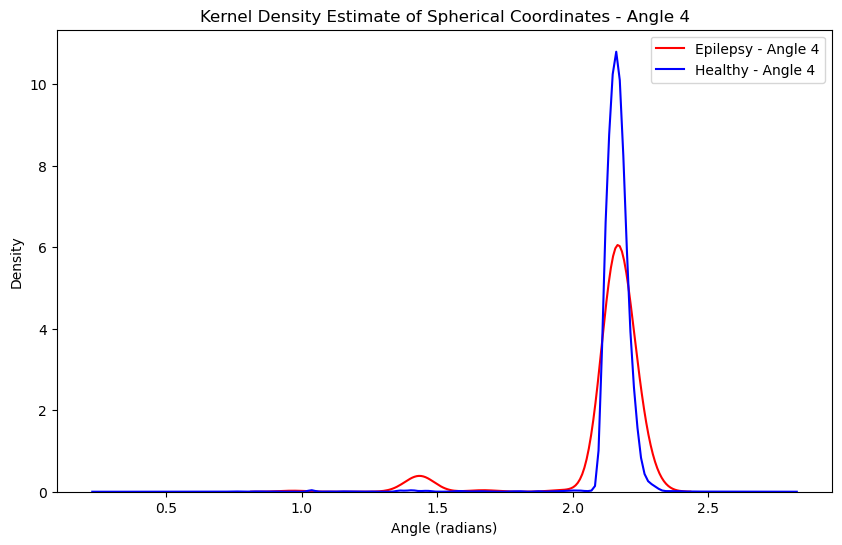

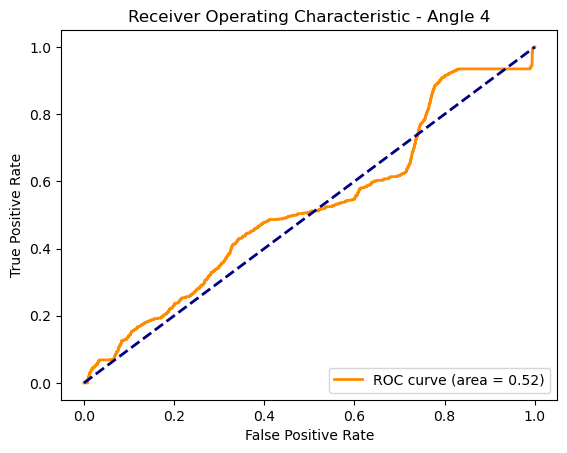

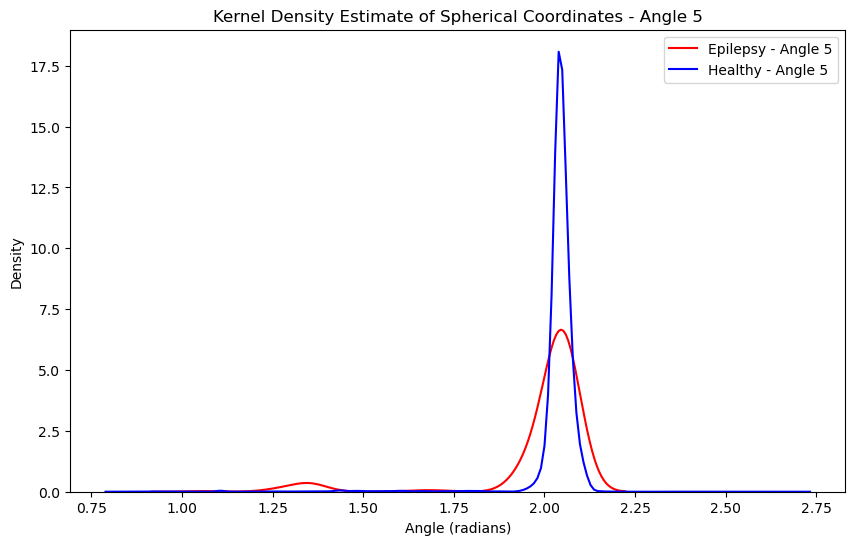

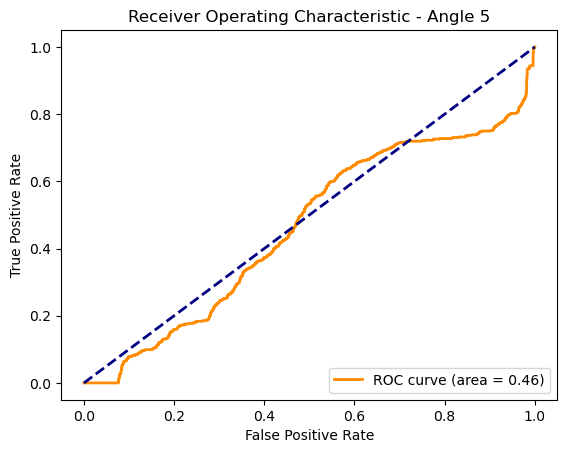

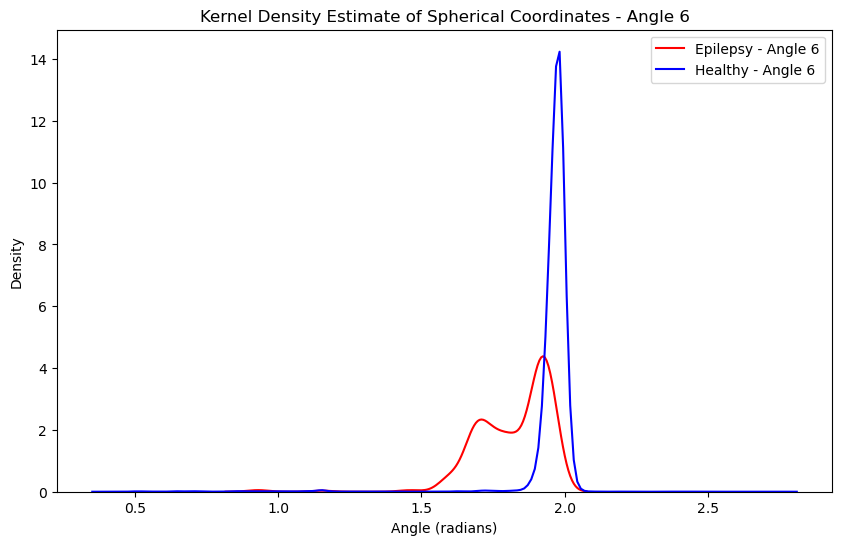

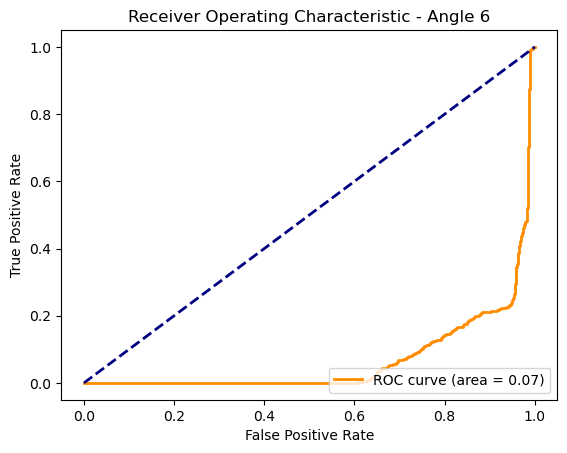

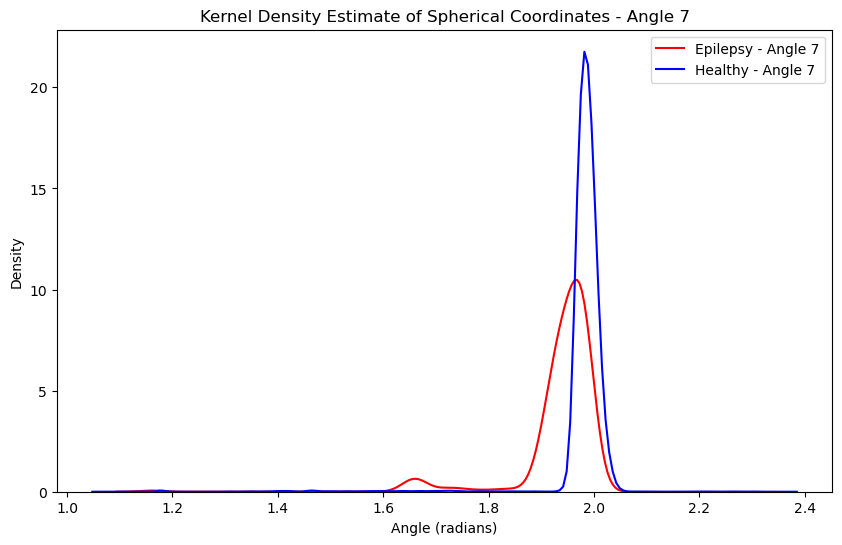

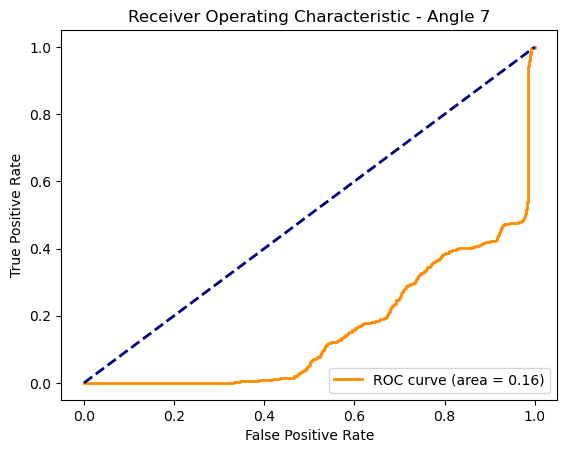

In [2]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec + right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random files from each folder
    epilepsy_file = random.choice([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')])
    healthy_file = random.choice([f for f in os.listdir(healthy_folder) if f.endswith('.fif')])

    epilepsy_angles = process_file(os.path.join(epilepsy_folder, epilepsy_file))
    healthy_angles = process_file(os.path.join(healthy_folder, healthy_file))

    # Combine data and create labels
    all_angles = np.vstack((epilepsy_angles, healthy_angles))
    labels = np.array([1] * len(epilepsy_angles) + [0] * len(healthy_angles))  # 1 for epilepsy, 0 for healthy

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, all_angles[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Angle {i+1}')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Joining 10 PDFs and Sed lyf!

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/2453290484.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKD

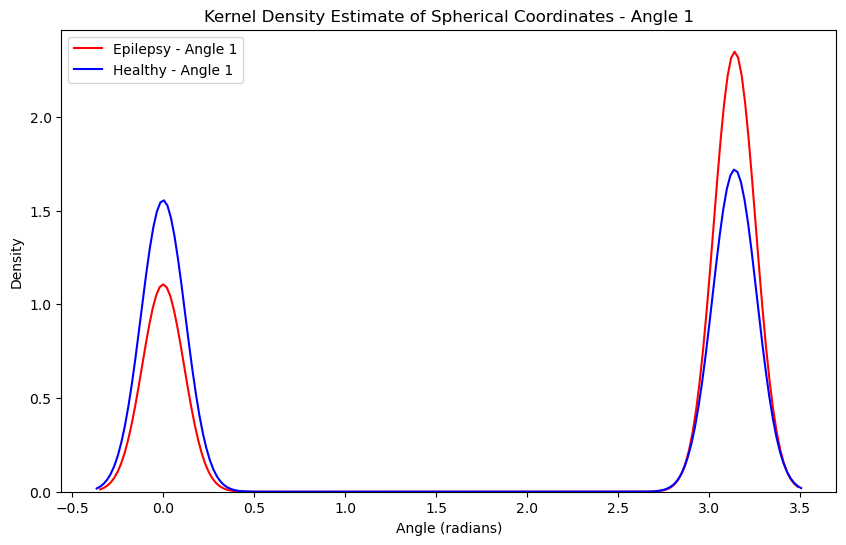

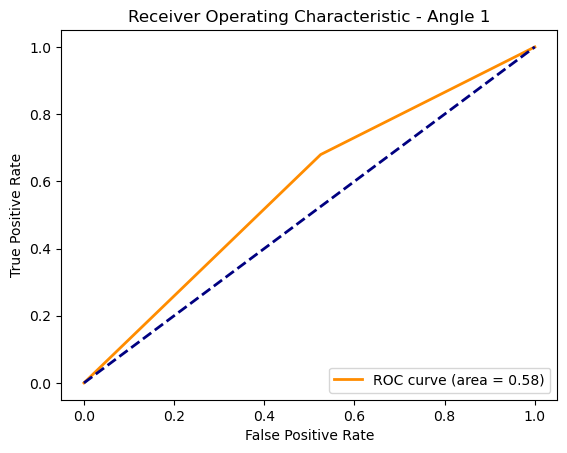

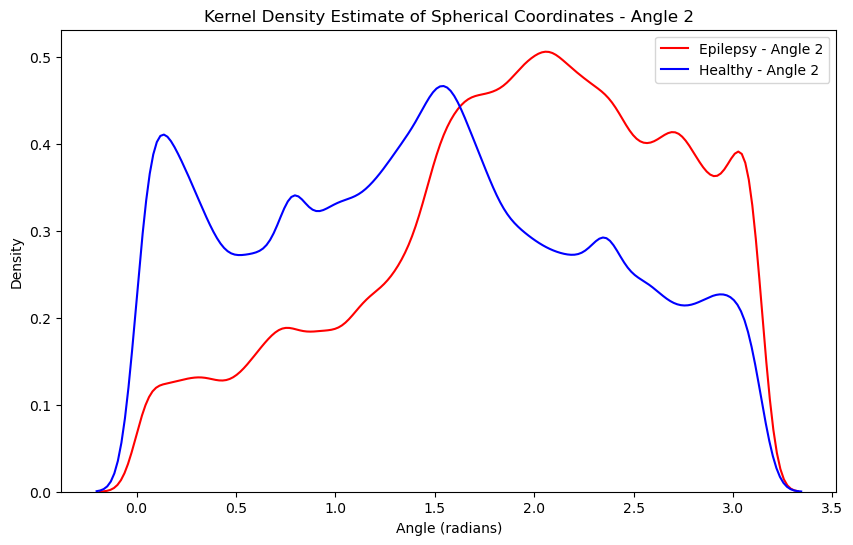

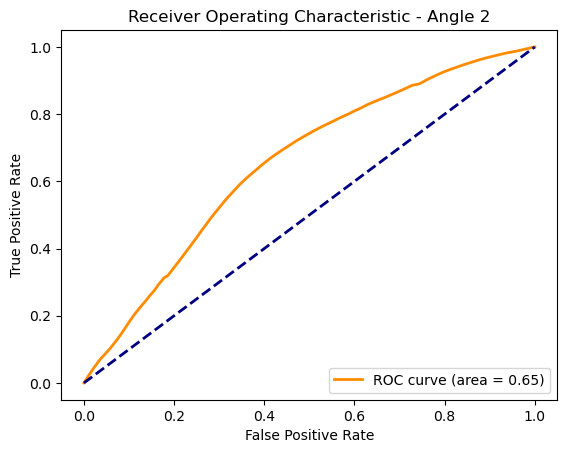

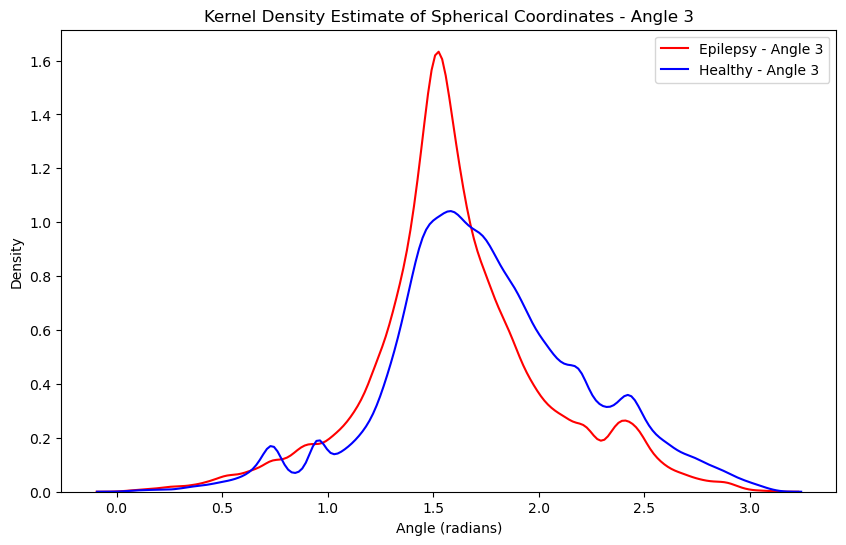

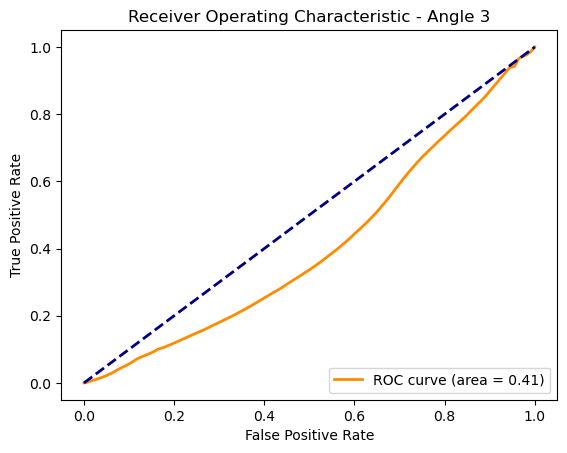

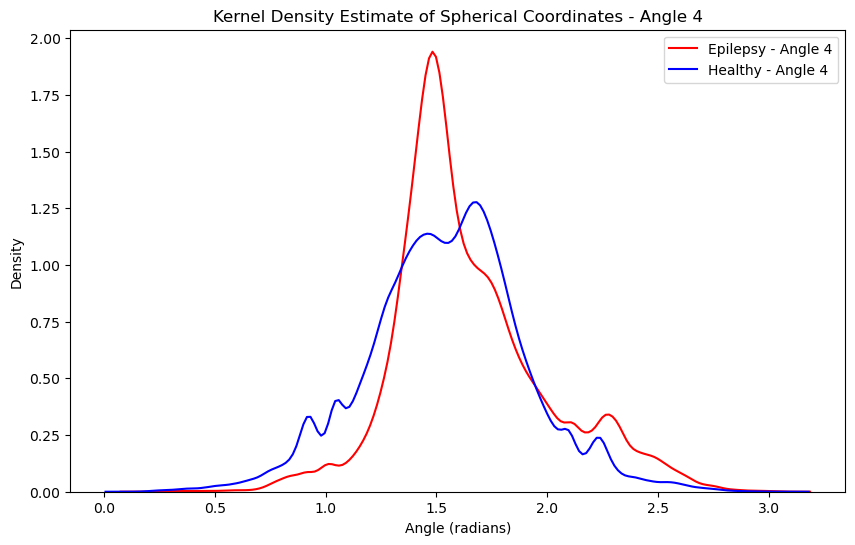

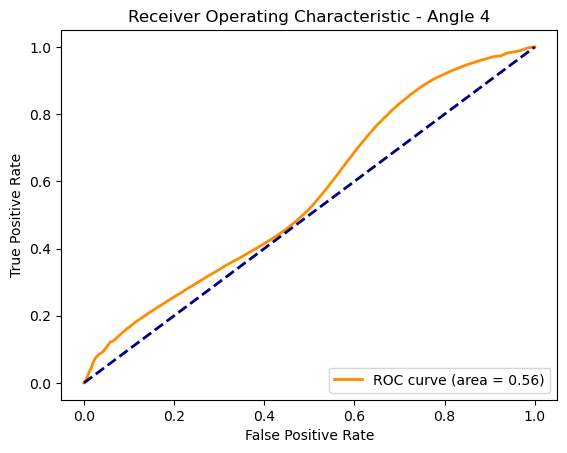

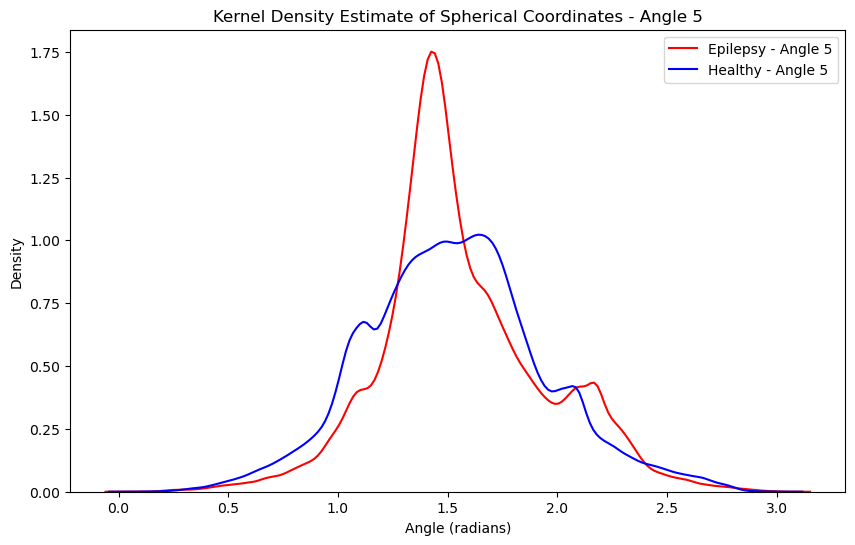

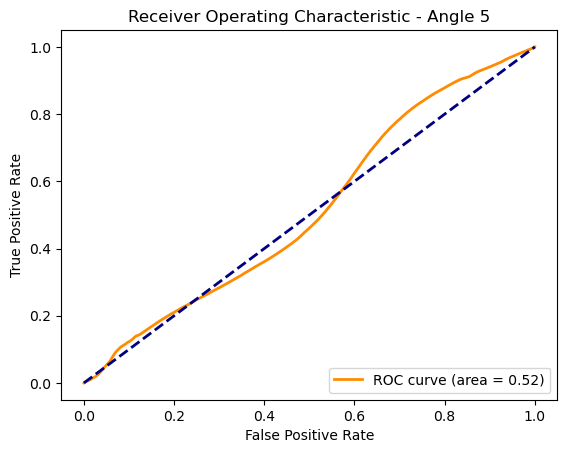

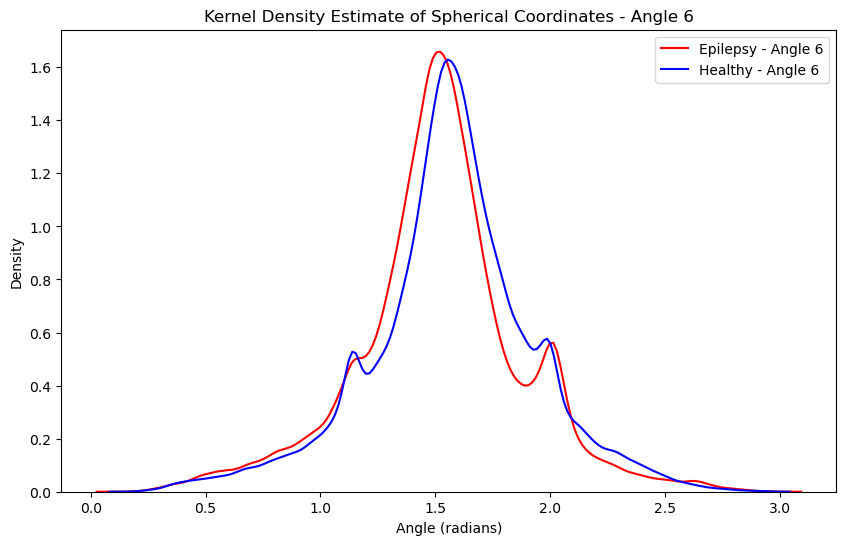

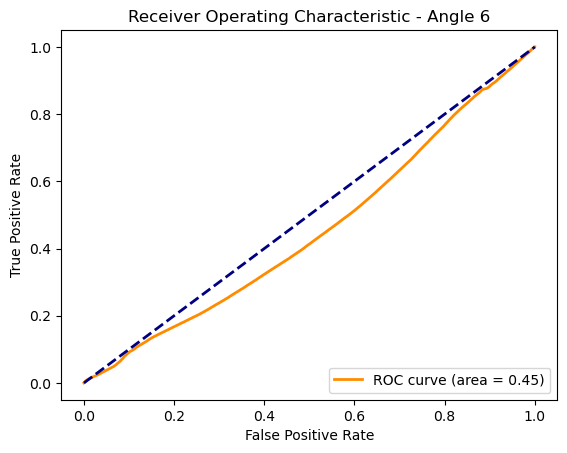

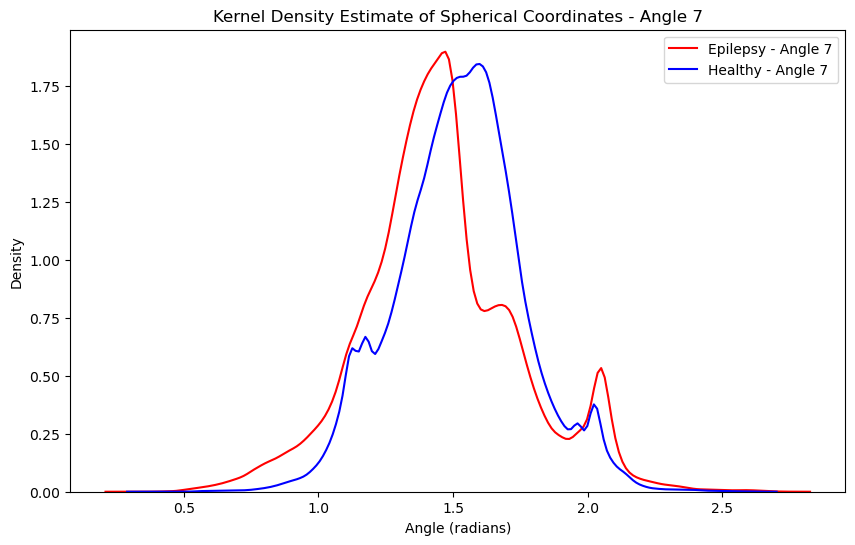

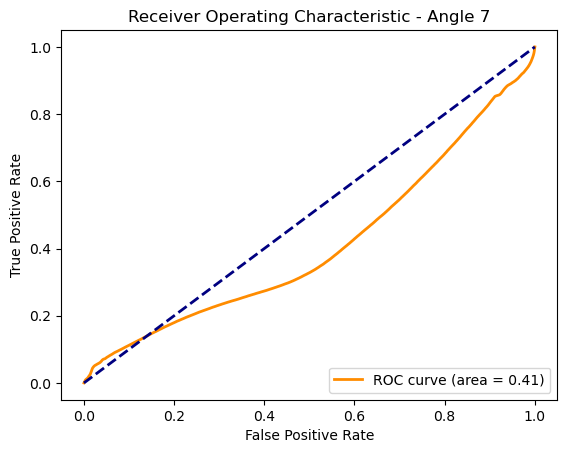

In [6]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process multiple files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get 10 random files from each folder
    epilepsy_files = random.sample([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')], 10)
    healthy_files = random.sample([f for f in os.listdir(healthy_folder) if f.endswith('.fif')], 10)

    all_epilepsy_angles = []
    all_healthy_angles = []

    for file in epilepsy_files:
        epilepsy_angles = process_file(os.path.join(epilepsy_folder, file))
        all_epilepsy_angles.append(epilepsy_angles)

    for file in healthy_files:
        healthy_angles = process_file(os.path.join(healthy_folder, file))
        all_healthy_angles.append(healthy_angles)

    all_epilepsy_angles = np.vstack(all_epilepsy_angles)
    all_healthy_angles = np.vstack(all_healthy_angles)

    # Combine data and create labels
    all_angles = np.vstack((all_epilepsy_angles, all_healthy_angles))
    labels = np.array([1] * len(all_epilepsy_angles) + [0] * len(all_healthy_angles))  # 1 for epilepsy, 0 for healthy

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(all_epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(all_healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, all_angles[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Angle {i+1}')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Add features

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301

Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD887

Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211

Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050

Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141

Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/284727004.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246

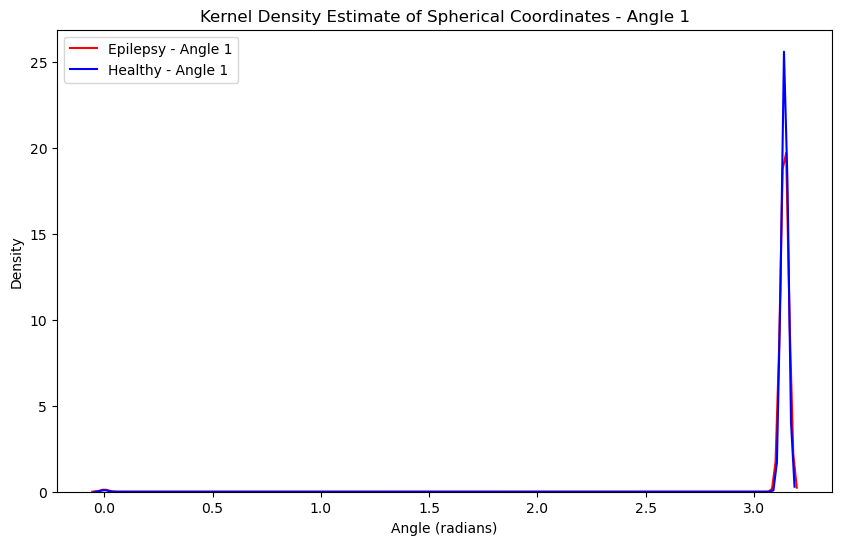

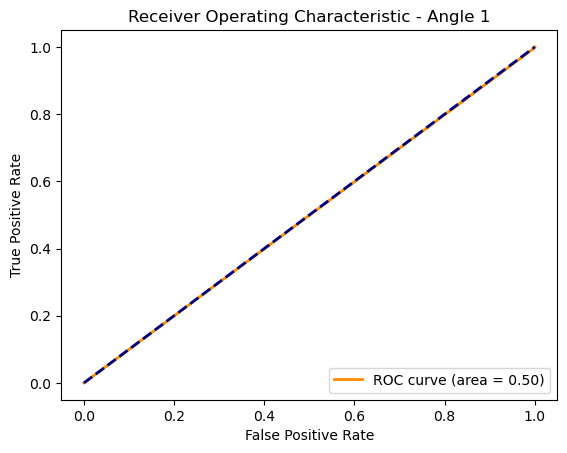

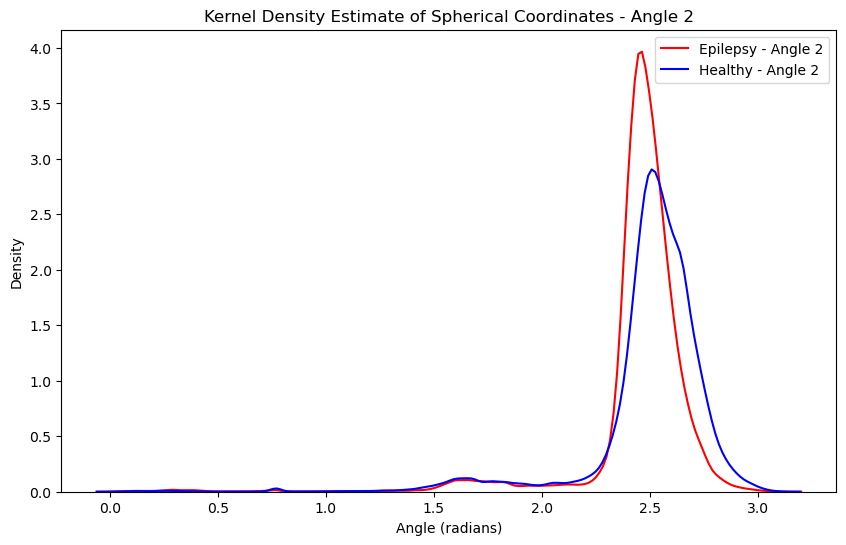

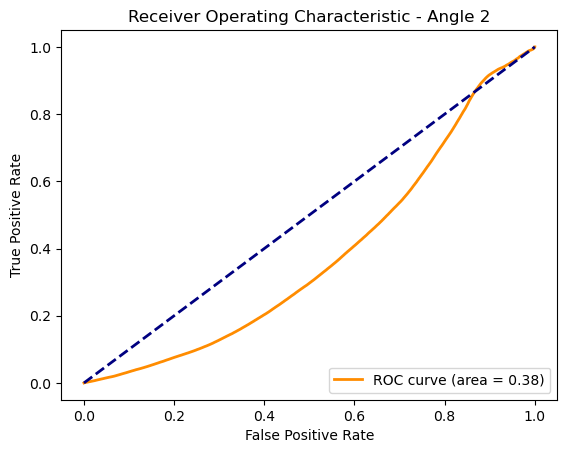

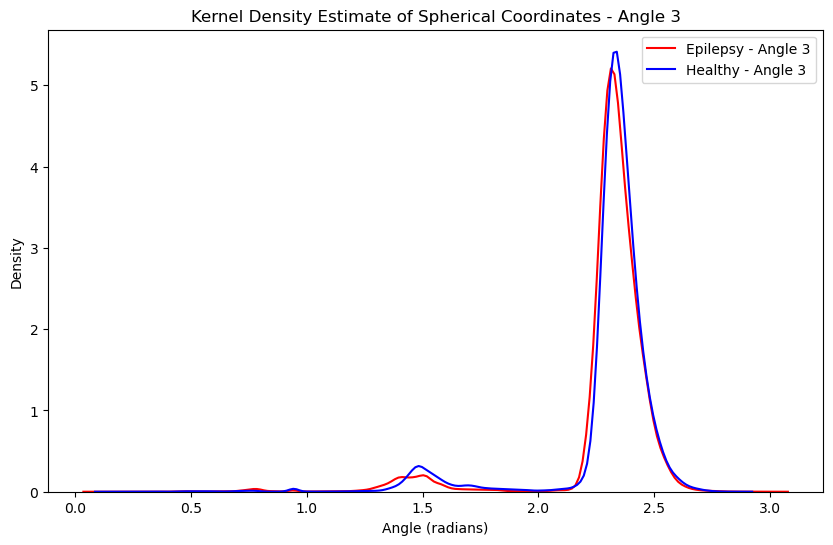

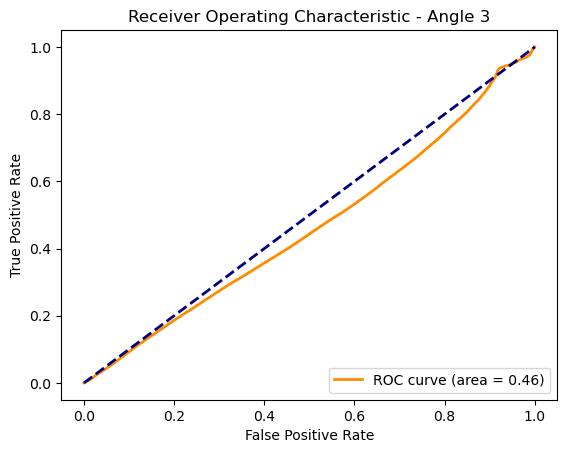

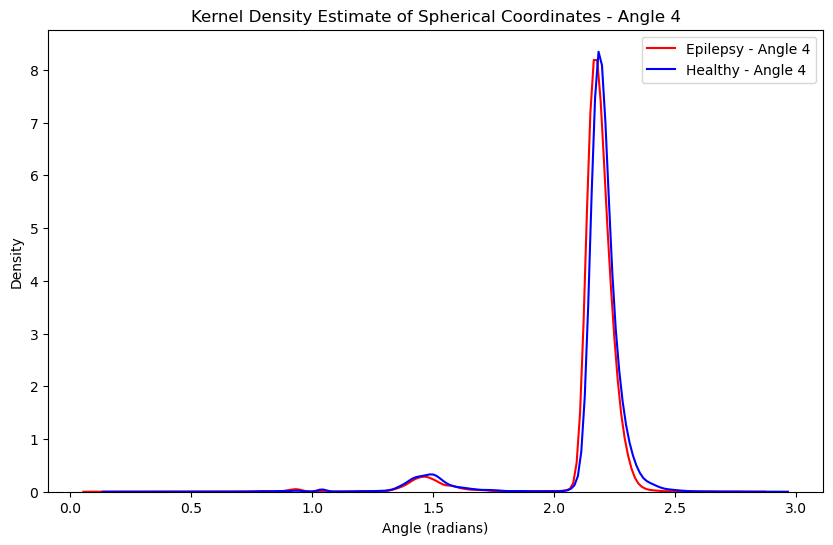

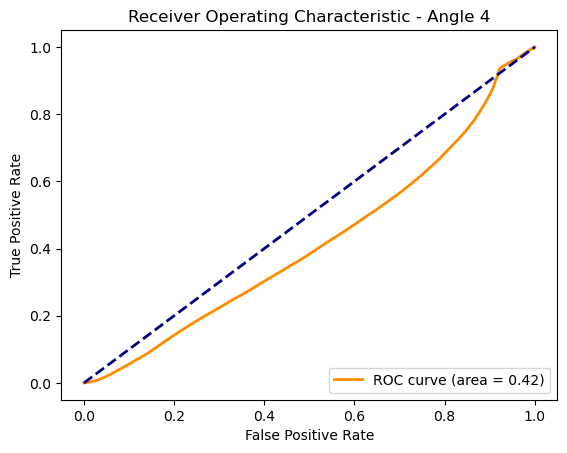

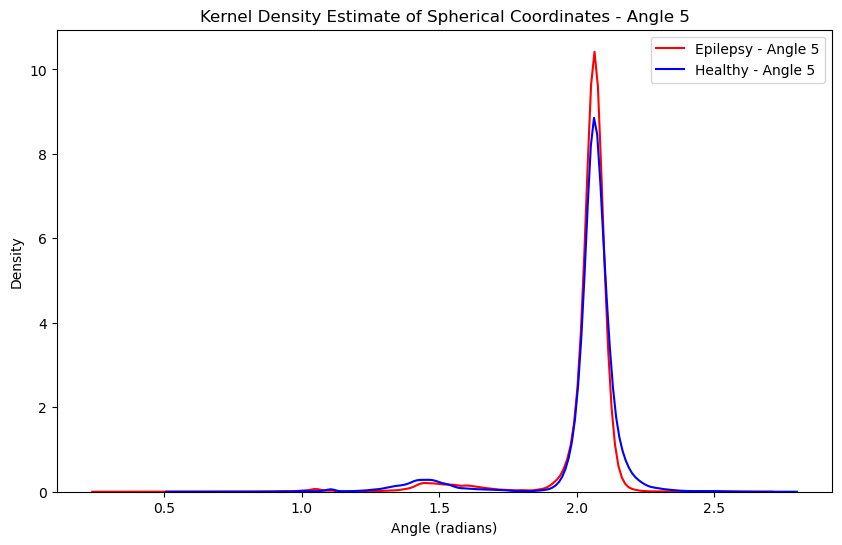

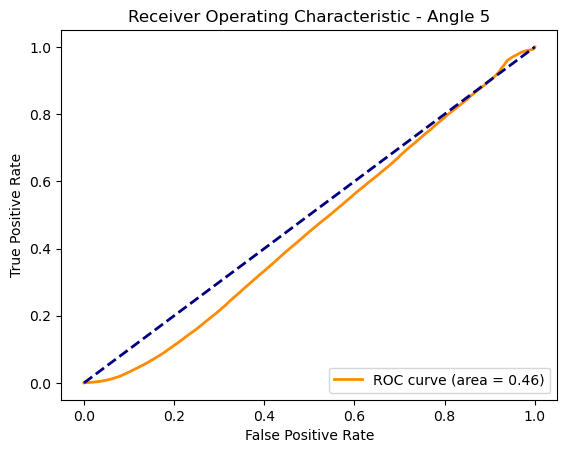

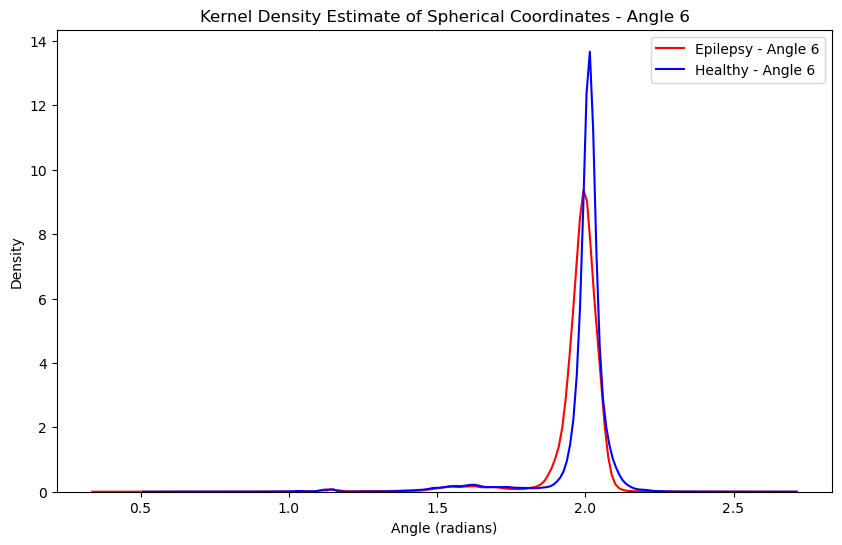

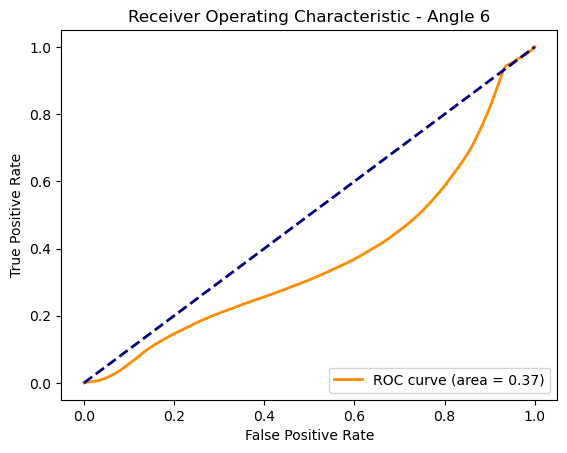

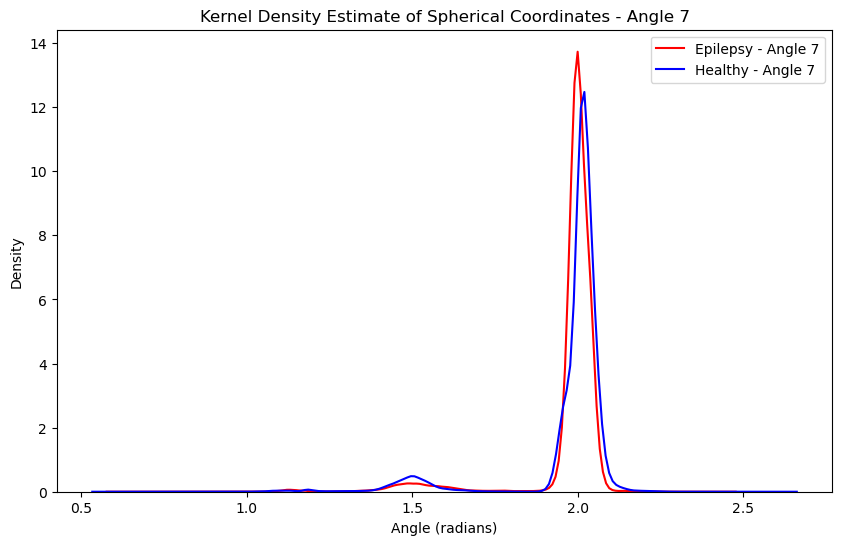

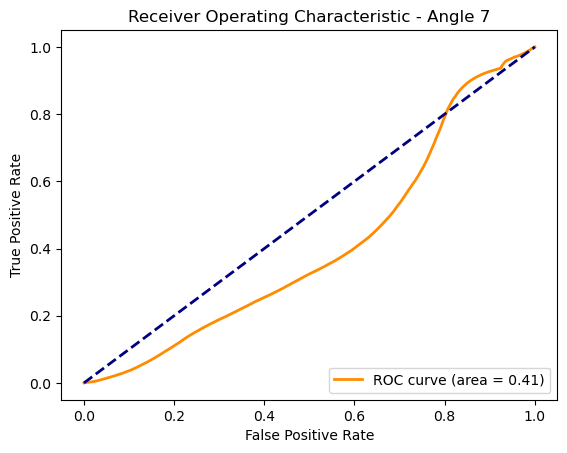

In [3]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec + right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process multiple files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get 10 random files from each folder
    epilepsy_files = random.sample([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')], 10)
    healthy_files = random.sample([f for f in os.listdir(healthy_folder) if f.endswith('.fif')], 10)

    all_epilepsy_angles = []
    all_healthy_angles = []

    for file in epilepsy_files:
        epilepsy_angles = process_file(os.path.join(epilepsy_folder, file))
        all_epilepsy_angles.append(epilepsy_angles)

    for file in healthy_files:
        healthy_angles = process_file(os.path.join(healthy_folder, file))
        all_healthy_angles.append(healthy_angles)

    all_epilepsy_angles = np.vstack(all_epilepsy_angles)
    all_healthy_angles = np.vstack(all_healthy_angles)

    # Combine data and create labels
    all_angles = np.vstack((all_epilepsy_angles, all_healthy_angles))
    labels = np.array([1] * len(all_epilepsy_angles) + [0] * len(all_healthy_angles))  # 1 for epilepsy, 0 for healthy

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(all_epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(all_healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, all_angles[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Angle {i+1}')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Joining 20 random PDFs and BAD lyf! ;-(
## Nontheless, there are interesting observations made already!

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525

Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD16

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508

Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160

Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301

Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246

Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080

Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271

Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221

Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160

Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001

Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220

Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/905722746.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004

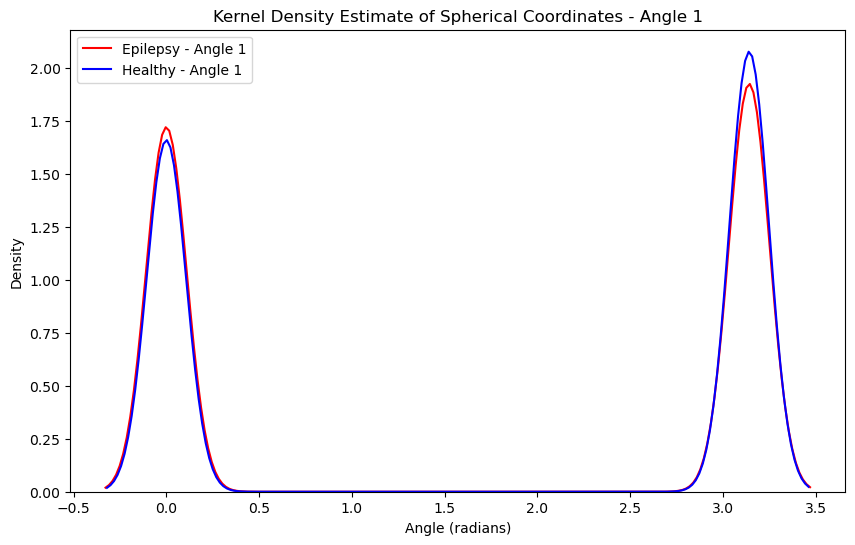

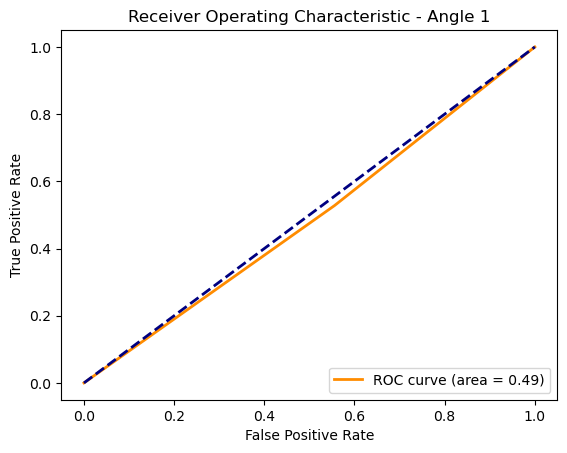

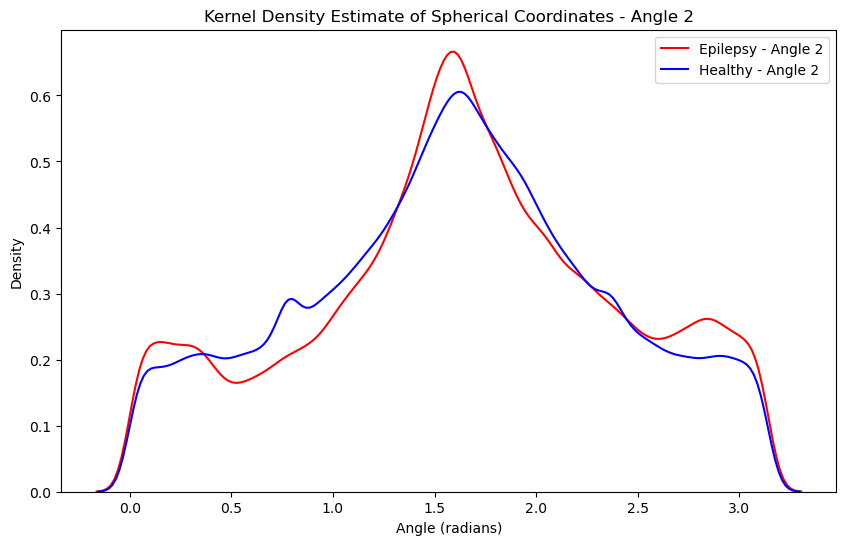

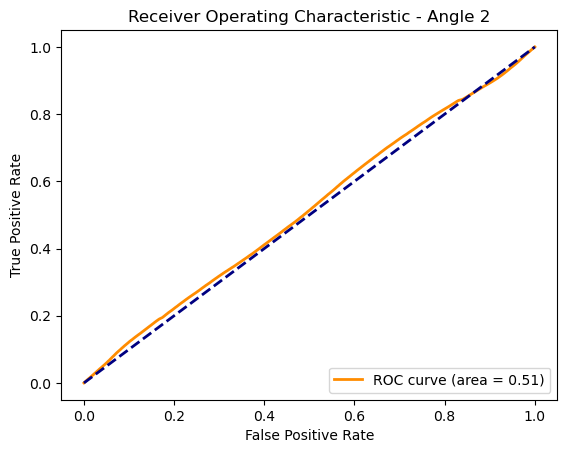

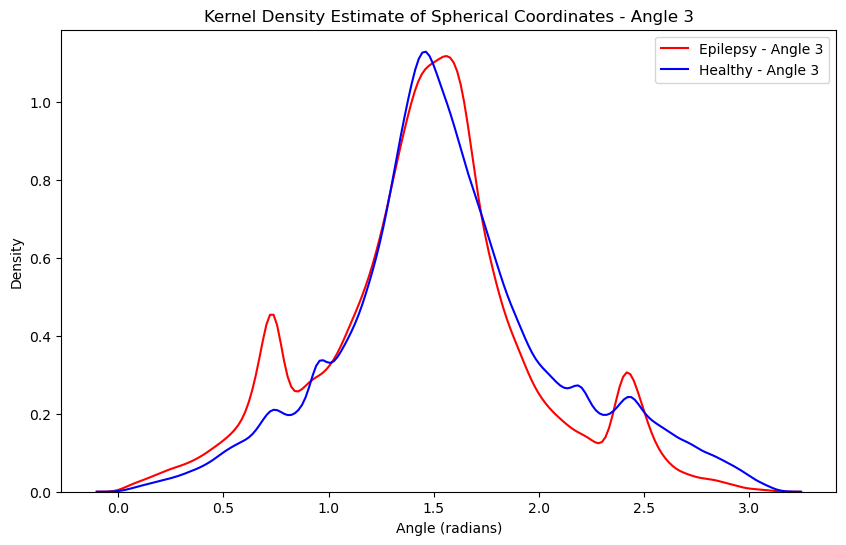

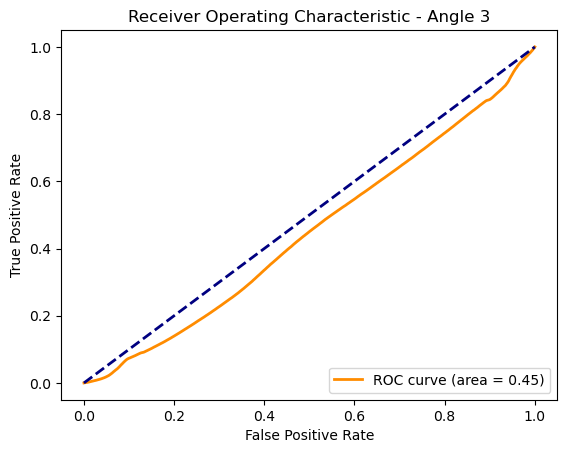

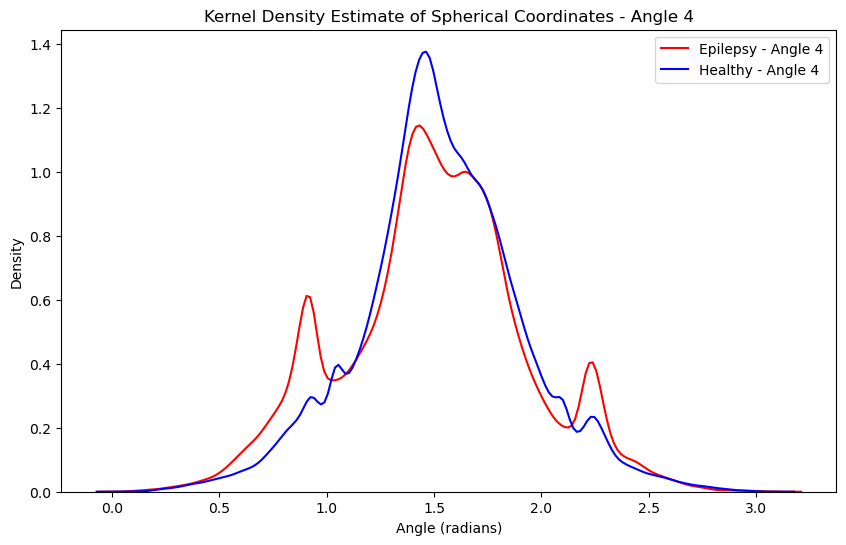

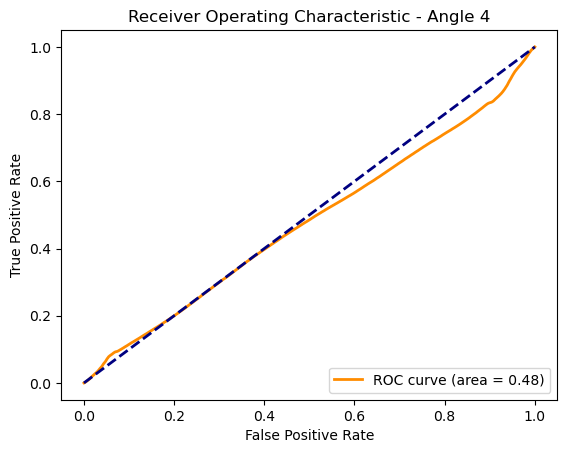

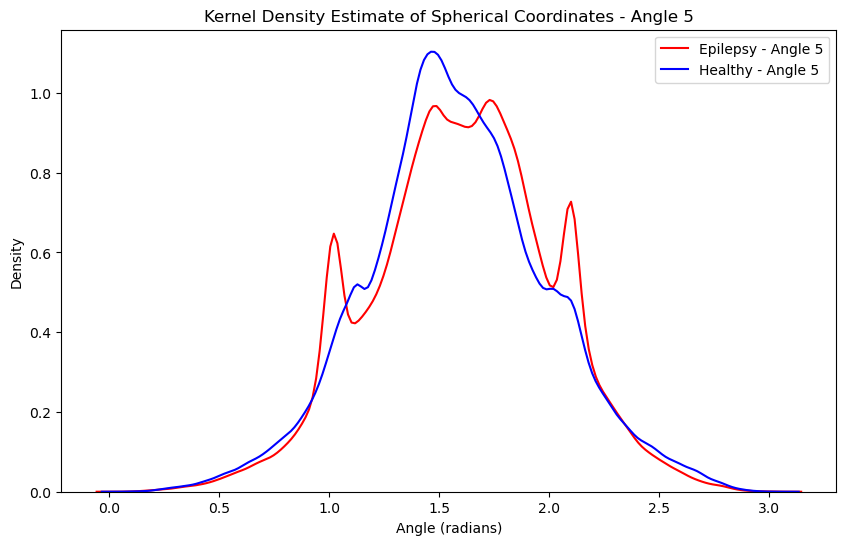

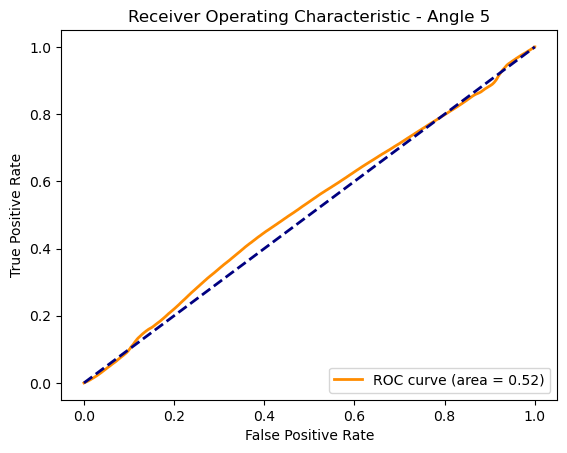

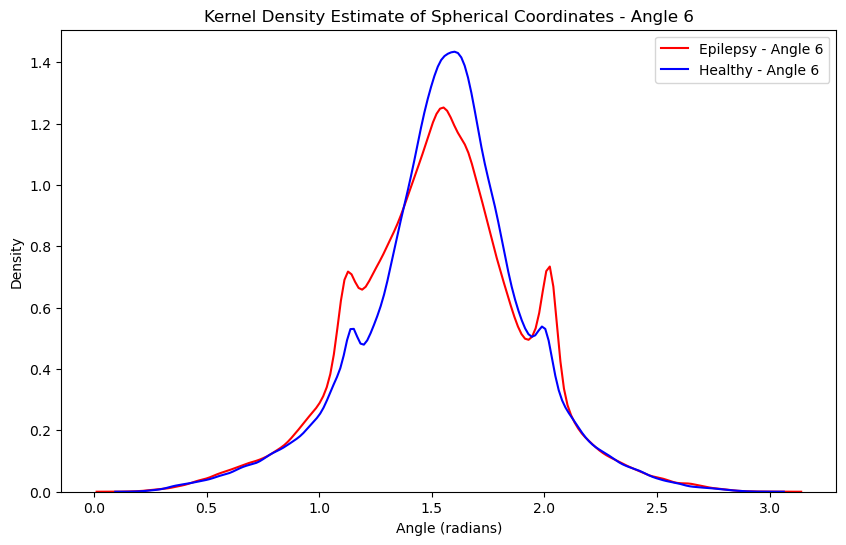

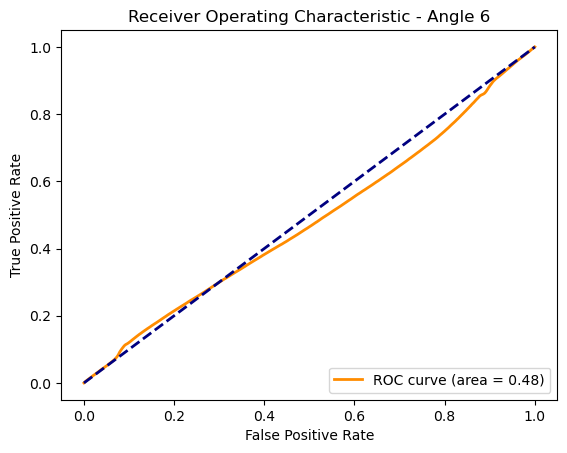

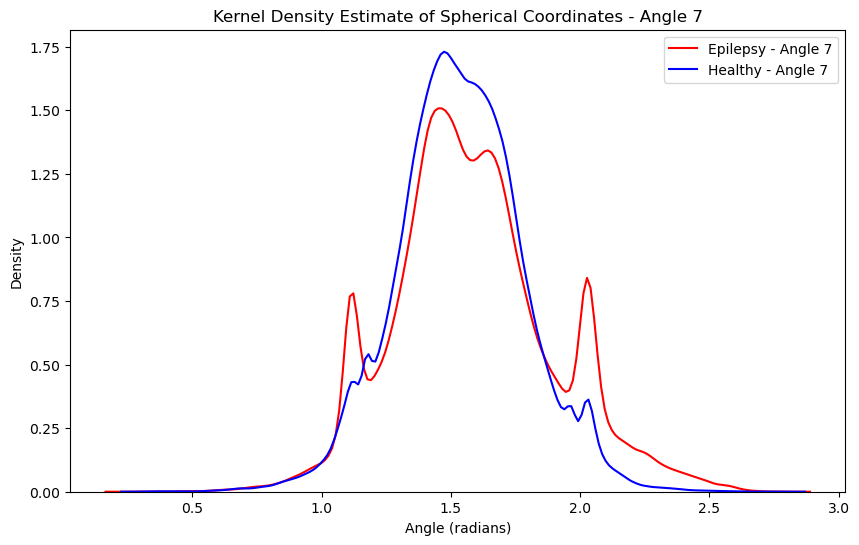

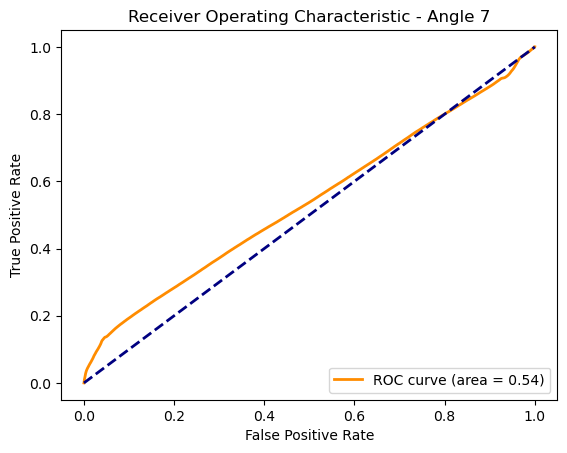

In [8]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process multiple files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get 10 random files from each folder
    epilepsy_files = random.sample([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')], 20)
    healthy_files = random.sample([f for f in os.listdir(healthy_folder) if f.endswith('.fif')], 20)

    all_epilepsy_angles = []
    all_healthy_angles = []

    for file in epilepsy_files:
        epilepsy_angles = process_file(os.path.join(epilepsy_folder, file))
        all_epilepsy_angles.append(epilepsy_angles)

    for file in healthy_files:
        healthy_angles = process_file(os.path.join(healthy_folder, file))
        all_healthy_angles.append(healthy_angles)

    all_epilepsy_angles = np.vstack(all_epilepsy_angles)
    all_healthy_angles = np.vstack(all_healthy_angles)

    # Combine data and create labels
    all_angles = np.vstack((all_epilepsy_angles, all_healthy_angles))
    labels = np.array([1] * len(all_epilepsy_angles) + [0] * len(all_healthy_angles))  # 1 for epilepsy, 0 for healthy

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(all_epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(all_healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, all_angles[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Angle {i+1}')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


## Add features

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKD

Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP

Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_4497/3489010241.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

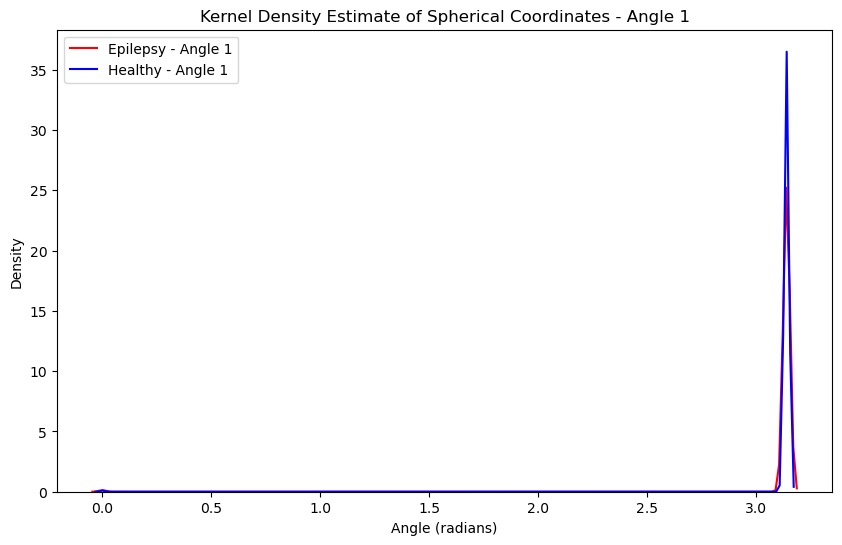

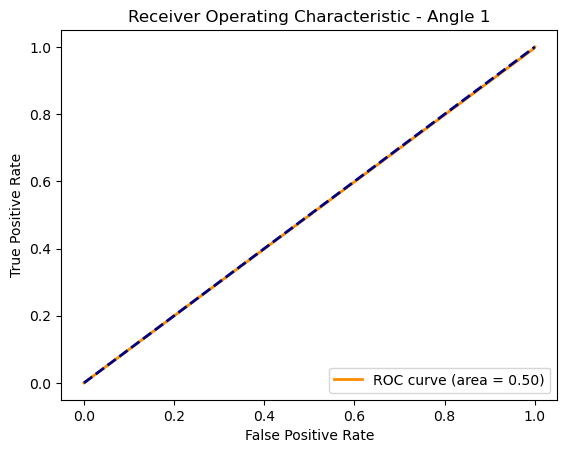

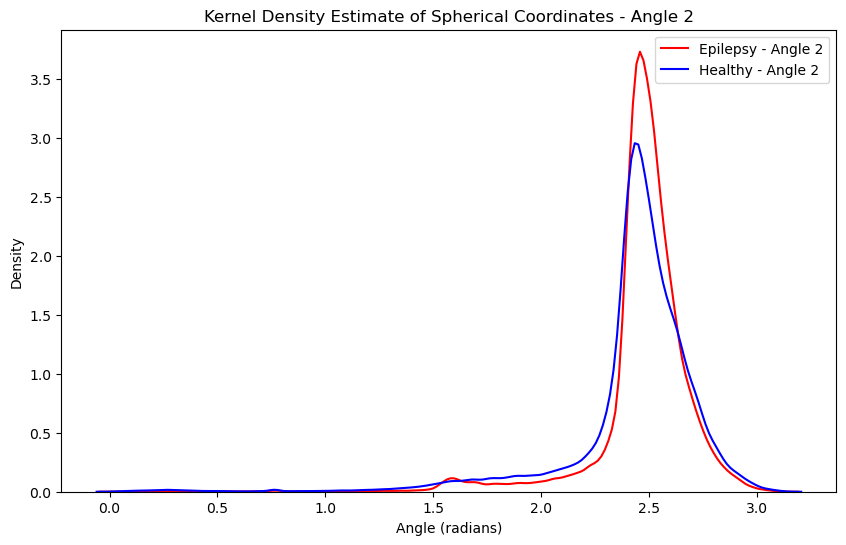

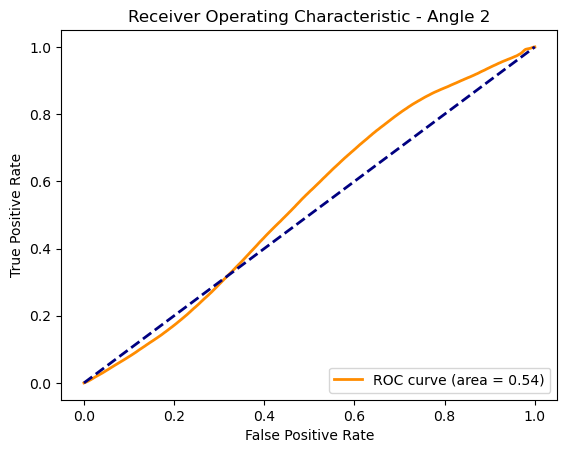

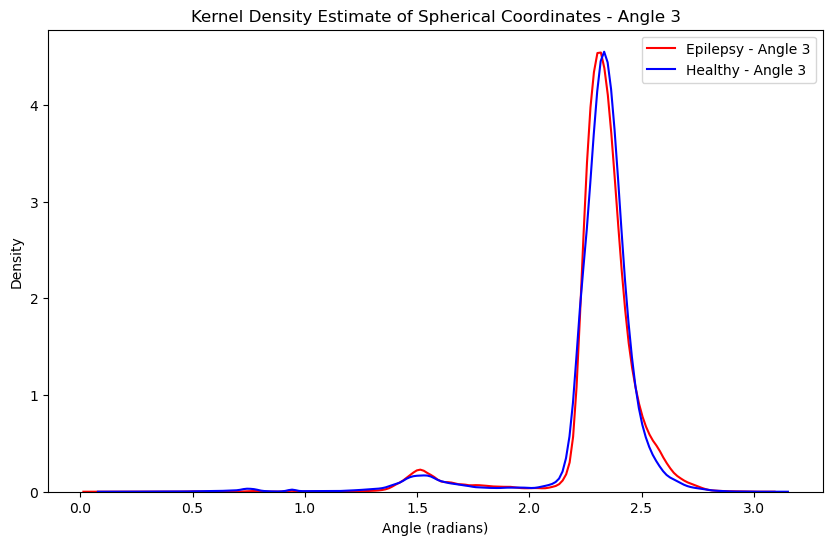

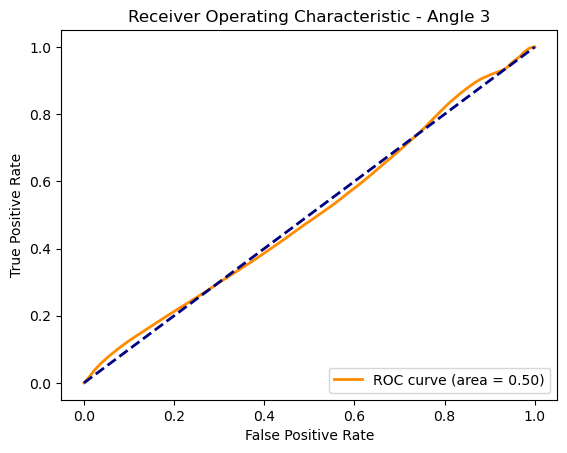

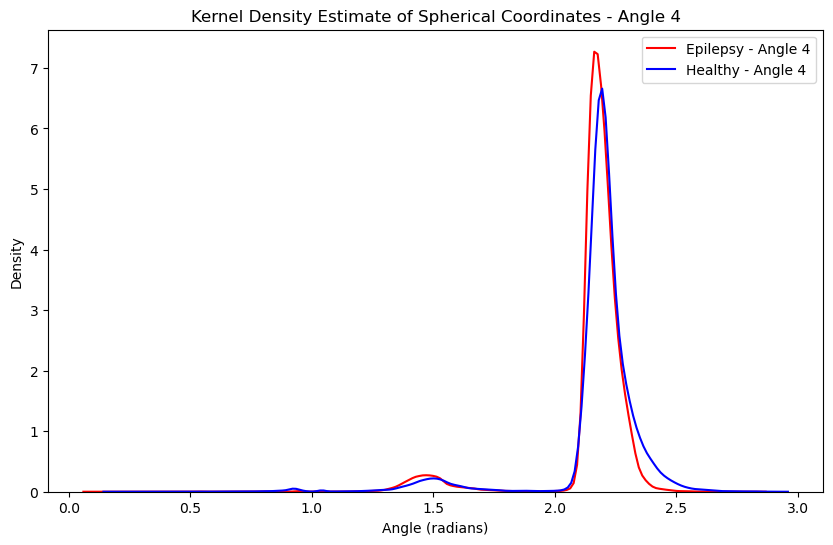

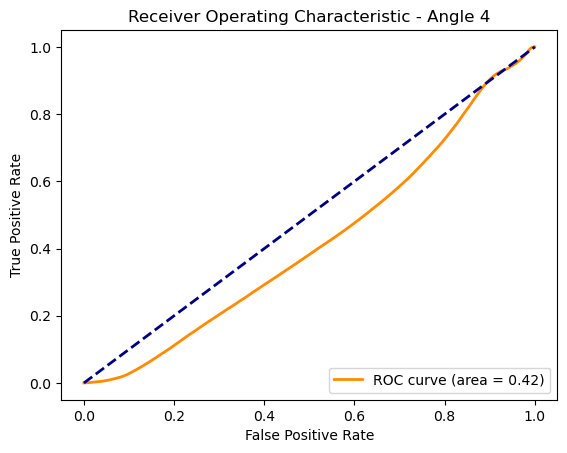

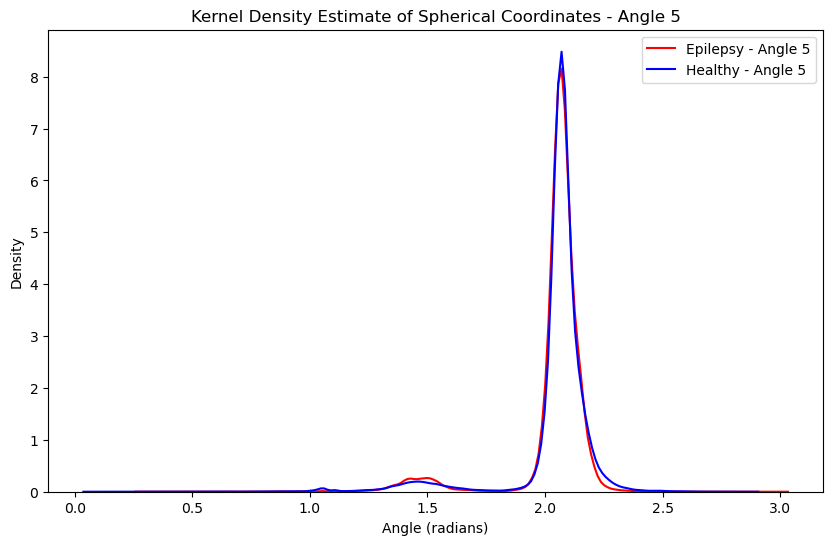

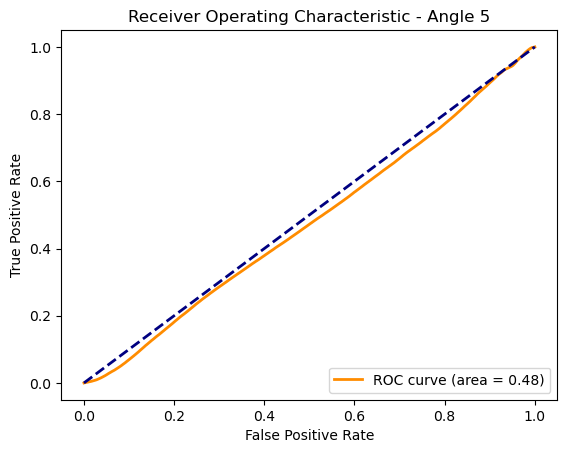

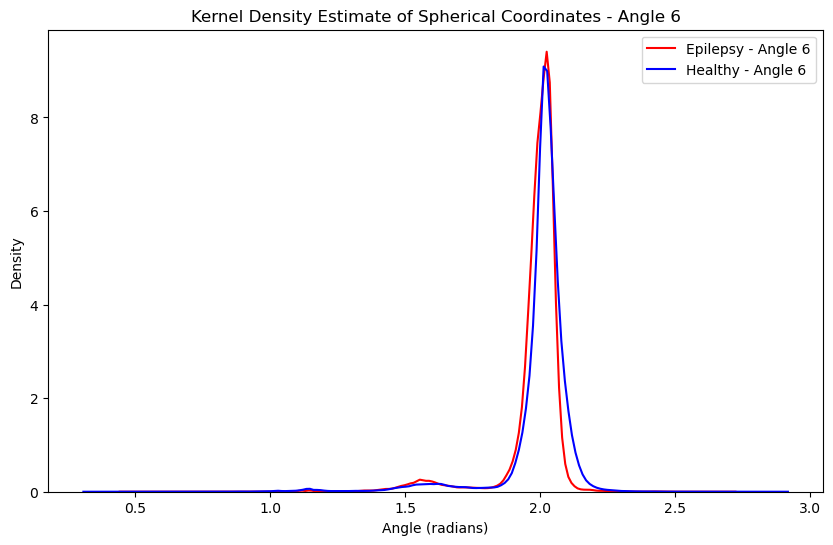

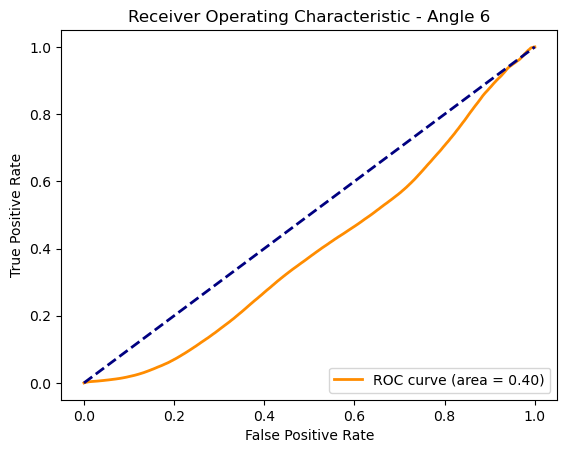

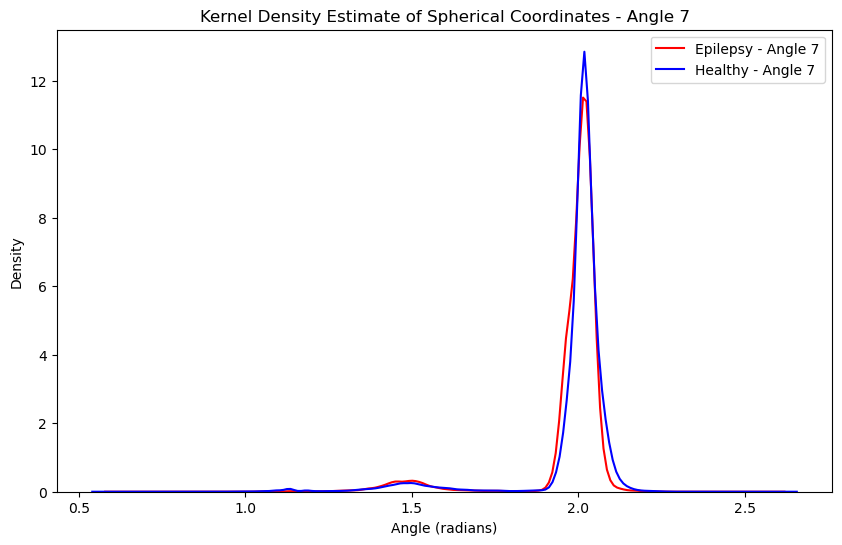

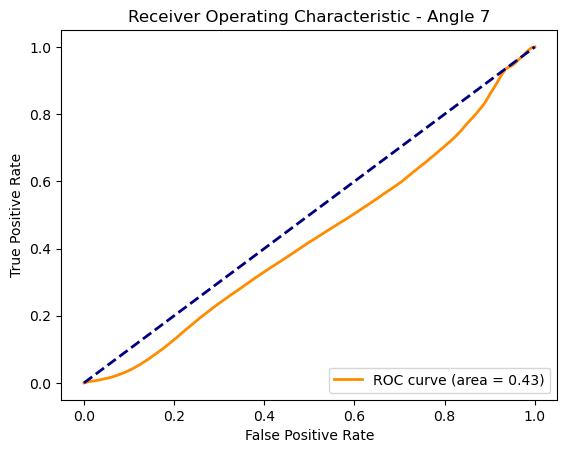

In [4]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec + right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process multiple files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get 10 random files from each folder
    epilepsy_files = random.sample([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')], 20)
    healthy_files = random.sample([f for f in os.listdir(healthy_folder) if f.endswith('.fif')], 20)

    all_epilepsy_angles = []
    all_healthy_angles = []

    for file in epilepsy_files:
        epilepsy_angles = process_file(os.path.join(epilepsy_folder, file))
        all_epilepsy_angles.append(epilepsy_angles)

    for file in healthy_files:
        healthy_angles = process_file(os.path.join(healthy_folder, file))
        all_healthy_angles.append(healthy_angles)

    all_epilepsy_angles = np.vstack(all_epilepsy_angles)
    all_healthy_angles = np.vstack(all_healthy_angles)

    # Combine data and create labels
    all_angles = np.vstack((all_epilepsy_angles, all_healthy_angles))
    labels = np.array([1] * len(all_epilepsy_angles) + [0] * len(all_healthy_angles))  # 1 for epilepsy, 0 for healthy

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(all_epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(all_healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, all_angles[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Angle {i+1}')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Apoon aur bhi pagalpanthi karega! 30 files joint PDFs and ROC observation.

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_N

Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT

Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKD

Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:19: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3672/3062786272.py:18: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

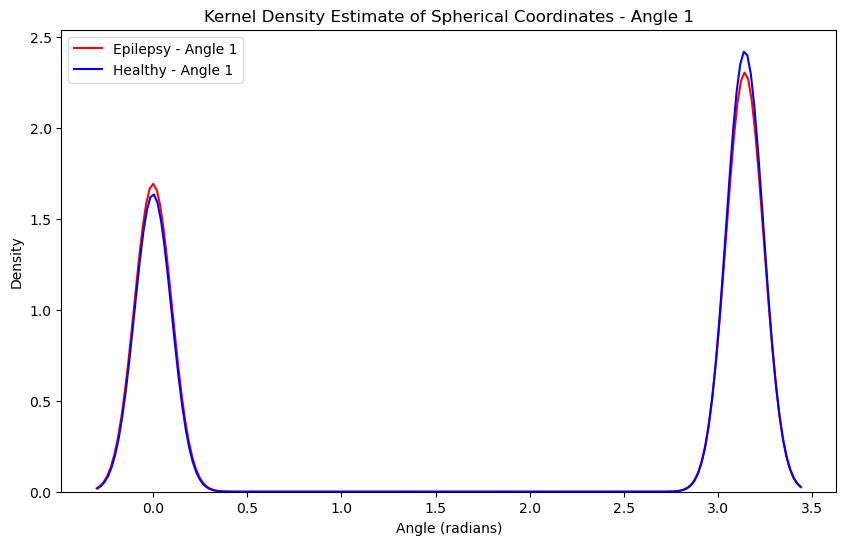

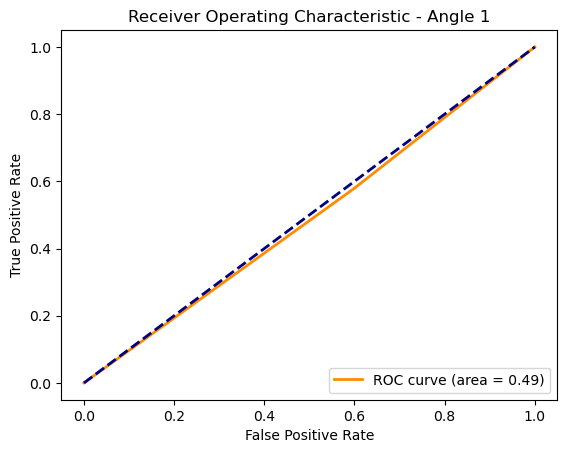

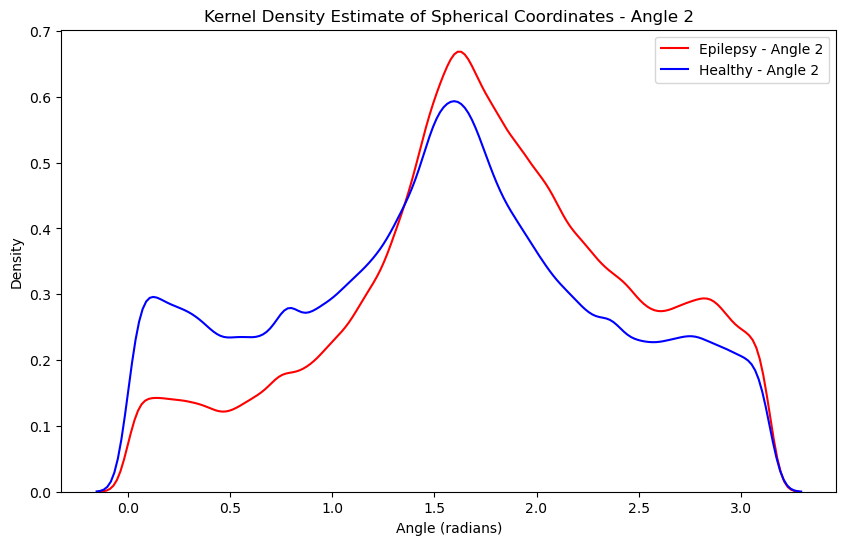

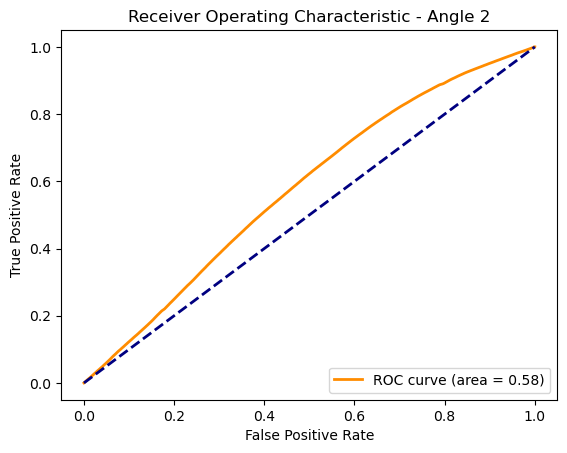

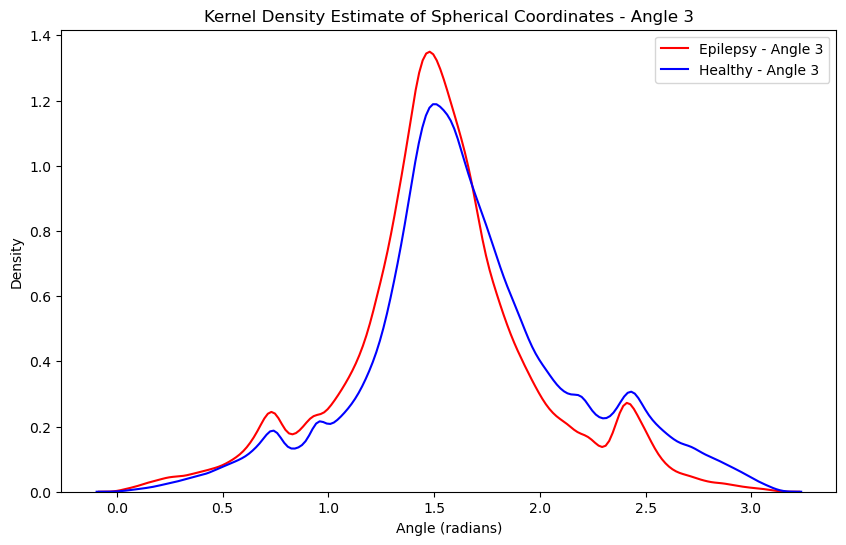

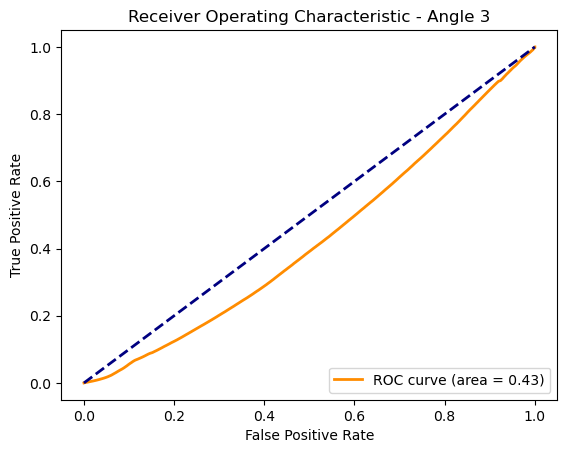

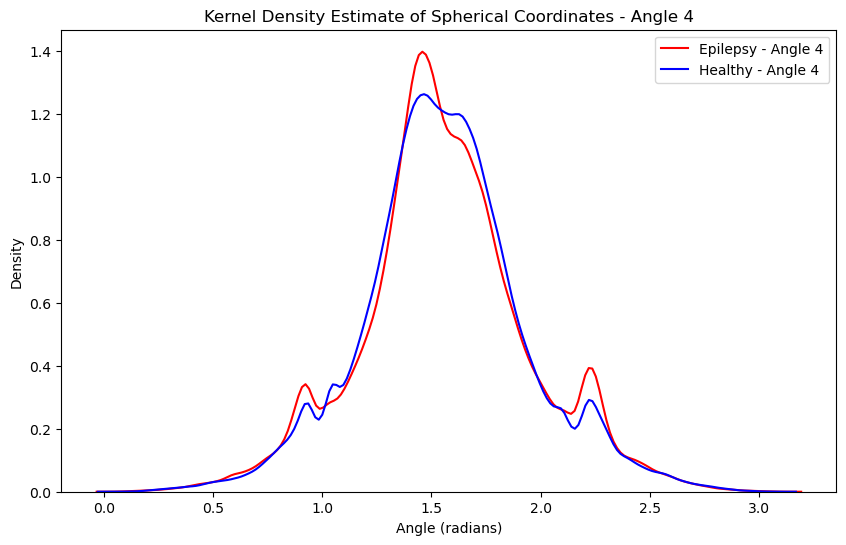

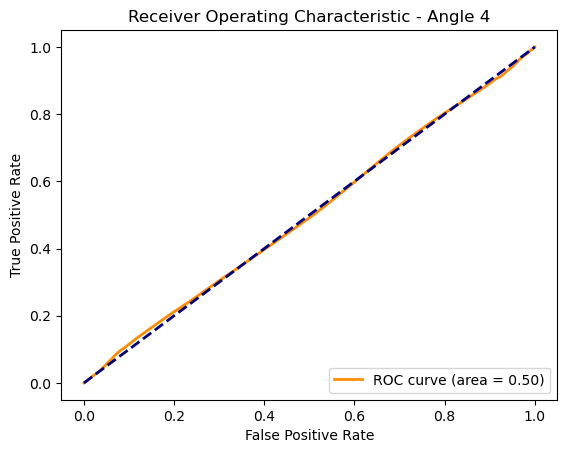

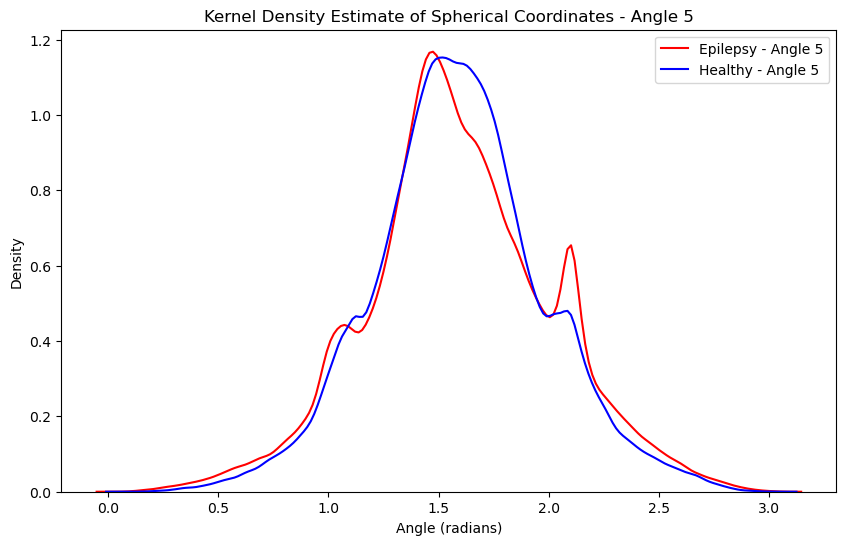

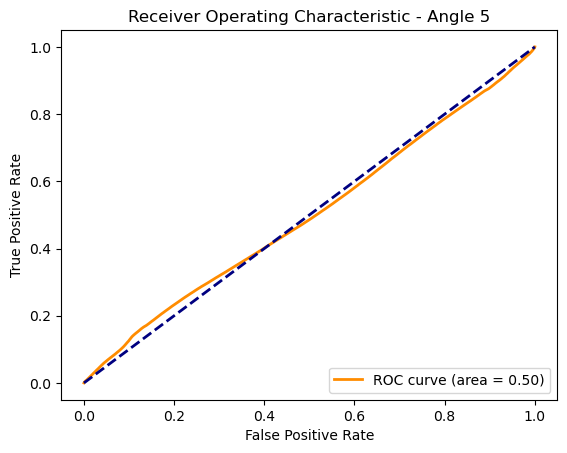

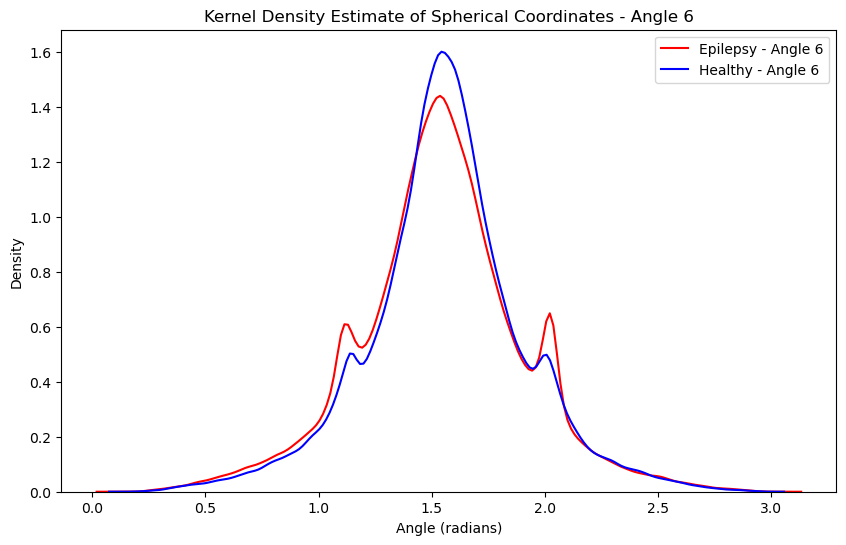

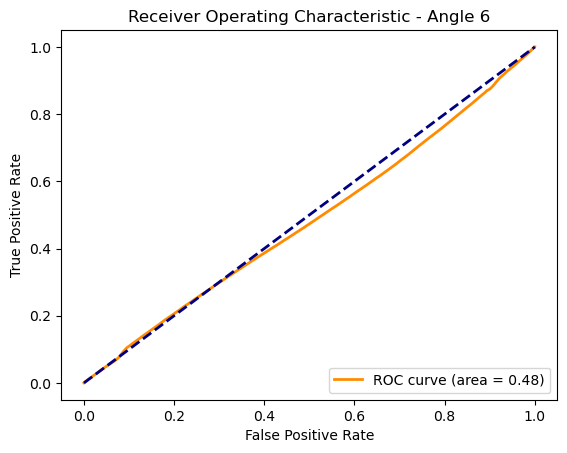

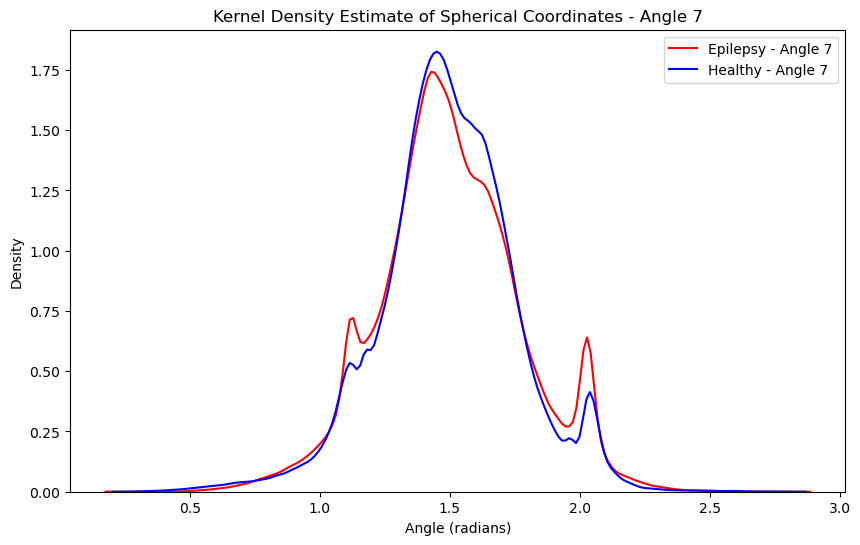

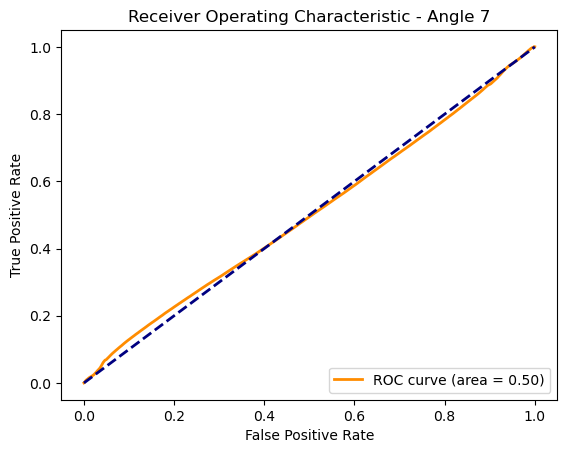

In [9]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process multiple files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get 10 random files from each folder
    epilepsy_files = random.sample([f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')], 30)
    healthy_files = random.sample([f for f in os.listdir(healthy_folder) if f.endswith('.fif')], 30)

    all_epilepsy_angles = []
    all_healthy_angles = []

    for file in epilepsy_files:
        epilepsy_angles = process_file(os.path.join(epilepsy_folder, file))
        all_epilepsy_angles.append(epilepsy_angles)

    for file in healthy_files:
        healthy_angles = process_file(os.path.join(healthy_folder, file))
        all_healthy_angles.append(healthy_angles)

    all_epilepsy_angles = np.vstack(all_epilepsy_angles)
    all_healthy_angles = np.vstack(all_healthy_angles)

    # Combine data and create labels
    all_angles = np.vstack((all_epilepsy_angles, all_healthy_angles))
    labels = np.array([1] * len(all_epilepsy_angles) + [0] * len(all_healthy_angles))  # 1 for epilepsy, 0 for healthy

    for i in range(7):
        plt.figure(figsize=(10, 6))
        sns.kdeplot(all_epilepsy_angles[:, i], label=f'Epilepsy - Angle {i+1}', color='r')
        sns.kdeplot(all_healthy_angles[:, i], label=f'Healthy - Angle {i+1}', color='b')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
        plt.title(f'Kernel Density Estimate of Spherical Coordinates - Angle {i+1}')
        plt.legend()
        plt.show()

        # ROC Curve
        fpr, tpr, _ = roc_curve(labels, all_angles[:, i])
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic - Angle {i+1}')
        plt.legend(loc="lower right")
        plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


# Just for fun!

In [1]:
import os
import numpy as np
from mne.io import read_raw_fif
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import kde

def extract_angles(file_path):
    # Read .fif file
    raw = read_raw_fif(file_path, preload=True)
    
    # Select channels
    left_channels = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
    right_channels = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']
    
    # Select and normalize left hemisphere data
    left_electrodes = raw.pick_channels(left_channels).get_data()
    left_electrodes_normalized = StandardScaler().fit_transform(left_electrodes)
    
    # Select and normalize right hemisphere data
    right_electrodes = raw.pick_channels(right_channels).get_data()
    right_electrodes_normalized = StandardScaler().fit_transform(right_electrodes)
    
    # Initialize empty list to store angles
    angles = []
    
    # Calculate covariance matrix and dominant eigenvector for each window
    window_size = int(raw.info['sfreq'])  # 1 second window
    stride = 10  # Stride of 10 samples
    
    for i in range(0, left_electrodes.shape[1] - window_size, stride):
        left_window_data = left_electrodes_normalized[:, i:i+window_size]
        right_window_data = right_electrodes_normalized[:, i:i+window_size]
        
        left_covariance_matrix = np.cov(left_window_data)
        left_dominant_eigenvector = np.linalg.eigh(left_covariance_matrix)[1][:, -1]
        
        right_covariance_matrix = np.cov(right_window_data)
        right_dominant_eigenvector = np.linalg.eigh(right_covariance_matrix)[1][:, -1]
        
        # Calculate angles between corresponding pairs of left and right dominant eigenvectors
        angle = np.arccos(np.clip(np.dot(left_dominant_eigenvector, right_dominant_eigenvector), -1.0, 1.0))
        angles.append(angle)
    
    return np.array(angles)

def plot_pdfs(angles):
    # Calculate and plot the PDF for each angle
    plt.figure(figsize=(15, 10))
    for i in range(7):
        data = angles[:, i]
        density = kde.gaussian_kde(data)
        x = np.linspace(min(data), max(data), 1000)
        plt.subplot(4, 2, i+1)
        plt.plot(x, density(x))
        plt.title(f'PDF of Angle {i+1}')
        plt.xlabel('Angle (radians)')
        plt.ylabel('Density')
    plt.tight_layout()
    plt.show()

# Path to a single file from the epilepsy folder
epilepsy_folder = "EEG Data_EE531/Epilepsy"
file_name = os.listdir(epilepsy_folder)[0]
file_path = os.path.join(epilepsy_folder, file_name)

# Extract angles for the file
angles = extract_angles(file_path)

# Plot PDFs of all 7 angles
plot_pdfs(angles)


Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/3124201531.py:10: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = read_raw_fif(file_path, preload=True)


Reading 0 ... 38250  =      0.000 ...   306.000 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/3124201531.py:17: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  left_electrodes = raw.pick_channels(left_channels).get_data()
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_5680/3124201531.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in an error because the following channel names are missing:
['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']
Either fix your included names or explicitly pass ordered=False.
  right_electrodes = raw.pick_channels(right_channels).get_data()


ValueError: No channels match the selection.

# New triplet experiment

Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)


Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change f

Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT

Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKD

Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_N

Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP

Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:18: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/1331123335.py:17: RuntimeWarning: This filename (EEG Data_EE531/Epi

Healthy Triplets: [array([-0.6066826 ,  0.22224567,  0.07591134]), array([-0.02554975,  0.07560446,  0.08826646]), array([-0.17867615,  0.31027033,  0.06852821]), array([-0.24756948,  0.14113228,  0.2197661 ]), array([-0.60642268,  0.420646  ,  0.49486092]), array([-0.24231746, -0.24213191, -0.32702993]), array([-0.51608243,  0.30585418,  0.39262818]), array([-0.38663849, -0.38817236,  0.15033533]), array([-0.53088645,  0.67878334, -0.13671103]), array([-0.56587097,  0.33016396,  0.12658995]), array([0.14179226, 0.45501785, 0.18390419]), array([-0.65564923,  1.11410137, -0.12243857]), array([ 0.111588  ,  0.17007358, -0.05855585]), array([0.0826317 , 0.30817738, 0.16385862]), array([ 0.49707081,  0.23225467, -0.22836475]), array([-0.17825958,  0.1490715 ,  0.39453058]), array([ 0.16168757, -0.00563609,  0.14014304]), array([ 0.11752516, -0.00227822,  0.15461276]), array([0.23524833, 0.07222037, 0.22772929]), array([-0.27744928,  0.3911048 , -0.03097832]), array([-0.7651964 ,  0.2389889

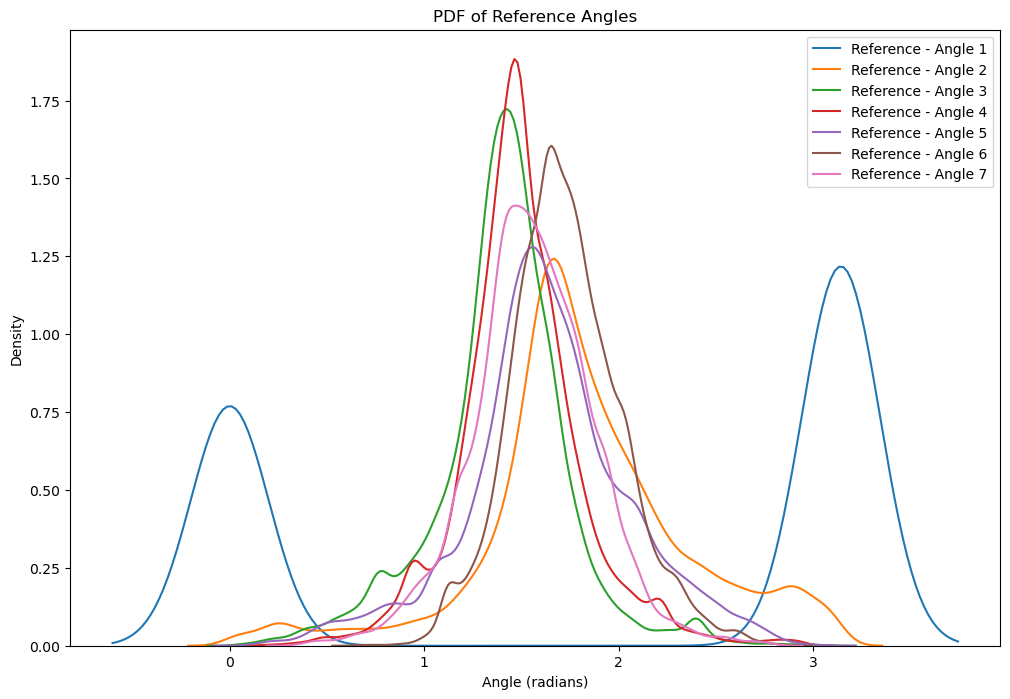

In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random file from healthy folder to use as reference
    healthy_files = [f for f in os.listdir(healthy_folder) if f.endswith('.fif')]
    reference_file = random.choice(healthy_files)
    reference_angles = process_file(os.path.join(healthy_folder, reference_file))

    # Calculate mean angles for the reference file
    reference_means = np.mean(reference_angles, axis=0)

    # Initialize lists for the mean difference triplets
    healthy_triplets = []
    epilepsy_triplets = []

    # Process other healthy files
    for file in healthy_files:
        if file == reference_file:
            continue
        angles = process_file(os.path.join(healthy_folder, file))
        mean_angles = np.mean(angles, axis=0)
        triplet = mean_angles[1:4] - reference_means[1:4]
        healthy_triplets.append(triplet)

    # Process epilepsy files
    epilepsy_files = [f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')]
    for file in epilepsy_files:
        angles = process_file(os.path.join(epilepsy_folder, file))
        mean_angles = np.mean(angles, axis=0)
        triplet = mean_angles[1:4] - reference_means[1:4]
        epilepsy_triplets.append(triplet)

    # Print the lists
    print("Healthy Triplets:", healthy_triplets)
    print("Epilepsy Triplets:", epilepsy_triplets)

    # Plot the PDF of the reference angles
    plt.figure(figsize=(12, 8))
    for i in range(7):
        sns.kdeplot(reference_angles[:, i], label=f'Reference - Angle {i+1}')
    plt.xlabel('Angle (radians)')
    plt.ylabel('Density')
    plt.title('PDF of Reference Angles')
    plt.legend()
    plt.show()

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


In [3]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming healthy_triplets and epilepsy_triplets are available as lists of triplets
# Convert lists to numpy arrays
healthy_triplets = np.array(healthy_triplets)
epilepsy_triplets = np.array(epilepsy_triplets)

# Create labels for the dataset
healthy_labels = np.zeros(len(healthy_triplets))  # Label 0 for healthy
epilepsy_labels = np.ones(len(epilepsy_triplets))  # Label 1 for epilepsy

# Combine the data and labels
X = np.vstack((healthy_triplets, epilepsy_triplets))
y = np.concatenate((healthy_labels, epilepsy_labels))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the SVM classifier
svm_clf = SVC(kernel='linear', C=1, random_state=42)

# Train the classifier
svm_clf.fit(X_train, y_train)

# Predict on the test set
y_pred = svm_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the accuracy metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


NameError: name 'healthy_triplets' is not defined

In [8]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random file from healthy folder to use as reference
    healthy_files = [f for f in os.listdir(healthy_folder) if f.endswith('.fif')]
    reference_file = random.choice(healthy_files)
    reference_angles = process_file(os.path.join(healthy_folder, reference_file))

    # Calculate mean angles for the reference file
    reference_means = np.mean(reference_angles, axis=0)

    # Initialize lists for the mean difference triplets
    healthy_triplets = []
    epilepsy_triplets = []

    # Process other healthy files
    for file in healthy_files:
        if file == reference_file:
            continue
        angles = process_file(os.path.join(healthy_folder, file))
        mean_angles = np.mean(angles, axis=0)
        triplet = mean_angles[1:4] - reference_means[1:4]
        healthy_triplets.append(triplet)

    # Process epilepsy files
    epilepsy_files = [f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')]
    for file in epilepsy_files:
        angles = process_file(os.path.join(epilepsy_folder, file))
        mean_angles = np.mean(angles, axis=0)
        triplet = mean_angles[1:4] - reference_means[1:4]
        epilepsy_triplets.append(triplet)

    # Print the lists
    print("Healthy Triplets:", healthy_triplets)
    print("Epilepsy Triplets:", epilepsy_triplets)

    # Combine the data for classification
    healthy_triplets = np.array(healthy_triplets)
    epilepsy_triplets = np.array(epilepsy_triplets)

    # Create labels for the dataset
    healthy_labels = np.zeros(len(healthy_triplets))  # Label 0 for healthy
    epilepsy_labels = np.ones(len(epilepsy_triplets))  # Label 1 for epilepsy

    # Combine the data and labels
    X = np.vstack((healthy_triplets, epilepsy_triplets))
    y = np.concatenate((healthy_labels, epilepsy_labels))

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize the SVM classifier
    svm_clf = SVC(kernel='rbf', C=1, random_state=42)

    # Train the classifier
    svm_clf.fit(X_train, y_train)

    # Predict on the test set
    y_pred = svm_clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print the accuracy metrics
    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Detailed classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", conf_matrix)

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT

Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKD

Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_N

Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP

Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:21: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/2277235924.py:20: RuntimeWarning: This filename (EEG Data_EE531/Epi

Healthy Triplets: [array([0.24231746, 0.24213191, 0.32702993]), array([-0.36436514,  0.46437758,  0.40294127]), array([0.21676771, 0.31773637, 0.41529639]), array([0.06364131, 0.55240223, 0.39555813]), array([-0.00525202,  0.38326419,  0.54679602]), array([-0.36410522,  0.66277791,  0.82189085]), array([-0.27376497,  0.54798609,  0.71965811]), array([-0.14432103, -0.14604045,  0.47736526]), array([-0.28856899,  0.92091525,  0.19031889]), array([-0.32355351,  0.57229587,  0.45361988]), array([0.38410972, 0.69714975, 0.51093412]), array([-0.41333176,  1.35623328,  0.20459135]), array([0.35390546, 0.41220549, 0.26847407]), array([0.32494916, 0.55030928, 0.49088855]), array([0.73938827, 0.47438658, 0.09866517]), array([0.06405789, 0.39120341, 0.72156051]), array([0.40400503, 0.23649581, 0.46717296]), array([0.35984262, 0.23985368, 0.48164269]), array([0.47756579, 0.31435227, 0.55475921]), array([-0.03513182,  0.63323671,  0.29605161]), array([-0.52287894,  0.4811209 ,  0.17620743]), array(

In [9]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Assuming healthy_triplets and epilepsy_triplets are already available
# Convert lists to numpy arrays
healthy_triplets = np.array(healthy_triplets)
epilepsy_triplets = np.array(epilepsy_triplets)

# Create labels for the dataset
healthy_labels = np.zeros(len(healthy_triplets))  # Label 0 for healthy
epilepsy_labels = np.ones(len(epilepsy_triplets))  # Label 1 for epilepsy

# Combine the data and labels
X = np.vstack((healthy_triplets, epilepsy_triplets))
y = np.concatenate((healthy_labels, epilepsy_labels))

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(3,)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.1, verbose=1)

# Evaluate the model on the test set
y_pred_prob = model.predict(X_test).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the accuracy metrics
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", conf_matrix)


NameError: name 'healthy_triplets' is not defined

In [10]:
import numpy as np
import os
import random
import mne
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Main function to process random files and plot the results
def main(epilepsy_folder, healthy_folder):
    # Get random file from healthy folder to use as reference
    healthy_files = [f for f in os.listdir(healthy_folder) if f.endswith('.fif')]
    reference_file = random.choice(healthy_files)
    reference_angles = process_file(os.path.join(healthy_folder, reference_file))

    # Calculate mean angles for the reference file
    reference_means = np.mean(reference_angles, axis=0)

    # Initialize lists for the mean difference triplets
    healthy_triplets = []
    epilepsy_triplets = []

    # Process other healthy files
    for file in healthy_files:
        if file == reference_file:
            continue
        angles = process_file(os.path.join(healthy_folder, file))
        mean_angles = np.mean(angles, axis=0)
        triplet = mean_angles[1:4] - reference_means[1:4]
        healthy_triplets.append(triplet)

    # Process epilepsy files
    epilepsy_files = [f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')]
    for file in epilepsy_files:
        angles = process_file(os.path.join(epilepsy_folder, file))
        mean_angles = np.mean(angles, axis=0)
        triplet = mean_angles[1:4] - reference_means[1:4]
        epilepsy_triplets.append(triplet)

    # Print the lists
    print("Healthy Triplets:", healthy_triplets)
    print("Epilepsy Triplets:", epilepsy_triplets)

    # Combine the data for classification
    healthy_triplets = np.array(healthy_triplets)
    epilepsy_triplets = np.array(epilepsy_triplets)

    # Create labels for the dataset
    healthy_labels = np.zeros(len(healthy_triplets))  # Label 0 for healthy
    epilepsy_labels = np.ones(len(epilepsy_triplets))  # Label 1 for epilepsy

    # Combine the data and labels
    X = np.vstack((healthy_triplets, epilepsy_triplets))
    y = np.concatenate((healthy_labels, epilepsy_labels))

    # Shuffle the data
    p = np.random.permutation(len(y))
    X, y = X[p], y[p]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build the ANN model
    model = Sequential([
        Dense(64, input_dim=3, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_test, y_test))

    # Evaluate the model
    y_pred = (model.predict(X_test) > 0.5).astype("int32")

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Print the accuracy metrics
    print("\nAccuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

    # Detailed classification report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:\n", conf_matrix)

if __name__ == '__main__':
    main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT

Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS

Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKD

Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_N

Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP

Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:22: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_2589/3600050025.py:21: RuntimeWarning: This filename (EEG Data_EE531/Epi

Healthy Triplets: [array([ 0.56587097, -0.33016396, -0.12658995]), array([-0.04081163, -0.10791829, -0.05067861]), array([ 0.54032122, -0.2545595 , -0.03832349]), array([ 0.38719482, -0.01989363, -0.05806175]), array([ 0.31830149, -0.18903168,  0.09317614]), array([-0.04055172,  0.09048204,  0.36827097]), array([ 0.32355351, -0.57229587, -0.45361988]), array([ 0.04978854, -0.02430978,  0.26603822]), array([ 0.17923248, -0.71833632,  0.02374537]), array([ 0.03498451,  0.34861938, -0.26330099]), array([0.70766323, 0.12485389, 0.05731423]), array([-0.08977826,  0.78393741, -0.24902853]), array([ 0.67745897, -0.16009038, -0.18514581]), array([ 0.64850267, -0.02198658,  0.03726867]), array([ 1.06294178, -0.09790929, -0.35495471]), array([ 0.38761139, -0.18109246,  0.26794063]), array([ 0.72755854, -0.33580005,  0.01355308]), array([ 0.68339613, -0.33244219,  0.02802281]), array([ 0.8011193 , -0.25794359,  0.10113933]), array([ 0.28842169,  0.06094084, -0.15756827]), array([-0.19932543, -0.0

In [13]:
# ROC Curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

NameError: name 'y_test' is not defined

# Mode difference features

In [12]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from scipy.stats import gaussian_kde
from sklearn.metrics import roc_curve, auc

# Constants
SAMPLING_FREQ = 125  # Hz
WINDOW_SIZE = 1 * SAMPLING_FREQ  # 1 second
STRIDE = 1  # sample
ELECTRODES_LEFT = ['EEG Fp1-REF', 'EEG F3-REF', 'EEG F7-REF', 'EEG C3-REF', 'EEG T3-REF', 'EEG P3-REF', 'EEG T5-REF', 'EEG O1-REF']
ELECTRODES_RIGHT = ['EEG Fp2-REF', 'EEG F4-REF', 'EEG F8-REF', 'EEG C4-REF', 'EEG T4-REF', 'EEG P4-REF', 'EEG T6-REF', 'EEG O2-REF']

# Function to load data from .fif files
def load_data(file_path, electrodes):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    picks = mne.pick_channels(raw.info['ch_names'], electrodes)
    data, _ = raw[picks, :]
    return data

# Function to compute the covariance matrix and dominant eigenvector
def dominant_eigenvector(data):
    cov_matrix = np.cov(data)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    dominant_vec = eigenvectors[:, np.argmax(eigenvalues)]
    return dominant_vec

# Function to convert a vector to spherical coordinates
def spherical_coordinates(vector):
    coords = []
    r = np.linalg.norm(vector)
    for i in range(1, len(vector)):
        r_i = np.linalg.norm(vector[:i])
        phi_i = np.arccos(vector[i-1] / r_i) if r_i != 0 else 0
        coords.append(phi_i)
    return coords

# Processing pipeline for a single file
def process_file(file_path):
    left_data = load_data(file_path, ELECTRODES_LEFT)
    right_data = load_data(file_path, ELECTRODES_RIGHT)

    num_windows = (left_data.shape[1] - WINDOW_SIZE) // STRIDE + 1

    all_angles = []

    for start in range(0, num_windows * STRIDE, STRIDE):
        end = start + WINDOW_SIZE

        left_window = left_data[:, start:end]
        right_window = right_data[:, start:end]

        left_window = (left_window - np.mean(left_window, axis=1, keepdims=True)) / np.std(left_window, axis=1, keepdims=True)
        right_window = (right_window - np.mean(right_window, axis=1, keepdims=True)) / np.std(right_window, axis=1, keepdims=True)

        left_vec = dominant_eigenvector(left_window)
        right_vec = dominant_eigenvector(right_window)

        feature_vector = left_vec - right_vec

        spherical_coords = spherical_coordinates(feature_vector)
        all_angles.append(spherical_coords)

    return np.array(all_angles)

# Function to find the mode of each angle's PDF
def find_mode(angles):
    modes = []
    for i in range(angles.shape[1]):
        kde = gaussian_kde(angles[:, i])
        grid = np.linspace(min(angles[:, i]), max(angles[:, i]), 1000)
        pdf = kde(grid)
        mode = grid[np.argmax(pdf)]
        modes.append(mode)
    return modes

# Main function to process files and compute the required differences
def main(epilepsy_folder, healthy_folder):
    # Get a random reference file from the healthy folder
    healthy_files = [f for f in os.listdir(healthy_folder) if f.endswith('.fif')]
    reference_file = random.choice(healthy_files)
    reference_angles = process_file(os.path.join(healthy_folder, reference_file))
    reference_modes = find_mode(reference_angles)

    healthy_triplets = []
    epilepsy_triplets = []

    # Process remaining healthy files
    for file in healthy_files:
        if file == reference_file:
            continue
        angles = process_file(os.path.join(healthy_folder, file))
        modes = find_mode(angles)
        triplet = [modes[1] - reference_modes[1], modes[2] - reference_modes[2], modes[3] - reference_modes[3],modes[4] - reference_modes[4],modes[5] - reference_modes[5],modes[6] - reference_modes[6]]
        healthy_triplets.append(triplet)

    # Process epilepsy files
    epilepsy_files = [f for f in os.listdir(epilepsy_folder) if f.endswith('.fif')]
    for file in epilepsy_files:
        angles = process_file(os.path.join(epilepsy_folder, file))
        modes = find_mode(angles)
        triplet = [modes[1] - reference_modes[1], modes[2] - reference_modes[2], modes[3] - reference_modes[3],modes[4] - reference_modes[4],modes[5] - reference_modes[5],modes[6] - reference_modes[6]]
        epilepsy_triplets.append(triplet)

    # Convert triplets to numpy arrays
    healthy_triplets = np.array(healthy_triplets)
    epilepsy_triplets = np.array(epilepsy_triplets)

    print("Healthy Triplets:", healthy_triplets)
    print("Epilepsy Triplets:", epilepsy_triplets)

    return healthy_triplets, epilepsy_triplets

if __name__ == '__main__':
    healthy_triplets, epilepsy_triplets = main('EEG Data_EE531/Epilepsy', 'EEG Data_EE531/Healthy')


Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif...
Isotrak not found
    Range : 23625 ... 50875 =    189.000 ...   407.000 secs
Ready.
Reading 0 ... 27250  =      0.000 ...   218.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD501623_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD501

Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif...
Isotrak not found
    Range : 24000 ... 49875 =    192.000 ...   399.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233497_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD233

Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif...
Isotrak not found
    Range : 20250 ... 57875 =    162.000 ...   463.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD141

Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif...
Isotrak not found
    Range : 22750 ... 63250 =    182.000 ...   506.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD021122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD021

Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif...
Isotrak not found
    Range : 23125 ... 63000 =    185.000 ...   504.000 secs
Ready.
Reading 0 ... 39875  =      0.000 ...   319.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD112

Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif...
Isotrak not found
    Range : 110125 ... 144500 =    881.000 ...  1156.000 secs
Ready.
Reading 0 ... 34375  =      0.000 ...   275.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638768_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD638

Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif...
Isotrak not found
    Range : 18375 ... 57000 =    147.000 ...   456.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160223_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160

Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif...
Isotrak not found
    Range : 26750 ... 67000 =    214.000 ...   536.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD887744_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD887

Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif...
Isotrak not found
    Range : 146125 ... 175250 =   1169.000 ...  1402.000 secs
Ready.
Reading 0 ... 29125  =      0.000 ...   233.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221993_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221

Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif...
Isotrak not found
    Range : 38125 ... 84250 =    305.000 ...   674.000 secs
Ready.
Reading 0 ... 46125  =      0.000 ...   369.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD261

Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif...
Isotrak not found
    Range : 18500 ... 57250 =    148.000 ...   458.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525376_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS525

Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54875 =    130.000 ...   439.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508857_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKCT508

Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif...
Isotrak not found
    Range : 33500 ... 71250 =    268.000 ...   570.000 secs
Ready.
Reading 0 ... 37750  =      0.000 ...   302.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004321_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS004

Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif...
Isotrak not found
    Range : 12750 ... 52875 =    102.000 ...   423.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001254_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS001

Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif...
Isotrak not found
    Range : 128750 ... 151375 =   1030.000 ...  1211.000 secs
Ready.
Reading 0 ... 22625  =      0.000 ...   181.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080880_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD080

Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif...
Isotrak not found
    Range : 44750 ... 74125 =    358.000 ...   593.000 secs
Ready.
Reading 0 ... 29375  =      0.000 ...   235.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200022_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD200

Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif...
Isotrak not found
    Range : 26500 ... 50250 =    212.000 ...   402.000 secs
Ready.
Reading 0 ... 23750  =      0.000 ...   190.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD240

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif...
Isotrak not found
    Range : 22750 ... 27500 =    182.000 ...   220.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif...
Isotrak not found
    Range : 500 ... 55750 =      4.000 ...   446.000 secs
Ready.
Reading 0 ... 55250  =      0.000 ...   442.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368

Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif...
Isotrak not found
    Range : 14000 ... 18250 =    112.000 ...   146.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368168_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD368

Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif...
Isotrak not found
    Range : 17875 ... 55750 =    143.000 ...   446.000 secs
Ready.
Reading 0 ... 37875  =      0.000 ...   303.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD271

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif...
Isotrak not found
    Range : 6500 ... 10750 =     52.000 ...    86.000 secs
Ready.
Reading 0 ... 4250  =      0.000 ...    34.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301

Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 53500 =    221.000 ...   428.000 secs
Ready.
Reading 0 ... 25875  =      0.000 ...   207.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050522_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD050

Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif...
Isotrak not found
    Range : 24250 ... 64750 =    194.000 ...   518.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD221

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif...
Isotrak not found
    Range : 22000 ... 60750 =    176.000 ...   486.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301

Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif...
Isotrak not found
    Range : 13000 ... 17500 =    104.000 ...   140.000 secs
Ready.
Reading 0 ... 4500  =      0.000 ...    36.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301122_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKMS301

Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif...
Isotrak not found
    Range : 20375 ... 60625 =    163.000 ...   485.000 secs
Ready.
Reading 0 ... 40250  =      0.000 ...   322.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD011

Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif...
Isotrak not found
    Range : 15375 ... 54750 =    123.000 ...   438.000 secs
Ready.
Reading 0 ... 39375  =      0.000 ...   315.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD1622023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD16

Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56250 =    132.000 ...   450.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211222_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD211

Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif...
Isotrak not found
    Range : 21375 ... 59875 =    171.000 ...   479.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160023_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD160

Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif...
Isotrak not found
    Range : 121250 ... 160000 =    970.000 ...  1280.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/HRV010_NewE

Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif...
Isotrak not found
    Range : 48750 ... 125000 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 76250  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP290716_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SHPP290

Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif...
Isotrak not found
    Range : 32625 ... 73000 =    261.000 ...   584.000 secs
Ready.
Reading 0 ... 40375  =      0.000 ...   323.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD270722_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD270

Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif...
Isotrak not found
    Range : 19000 ... 39875 =    152.000 ...   319.000 secs
Ready.
Reading 0 ... 20875  =      0.000 ...   167.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD220

Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif...
Isotrak not found
    Range : 19375 ... 61500 =    155.000 ...   492.000 secs
Ready.
Reading 0 ... 42125  =      0.000 ...   337.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246622_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD246

Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif...
Isotrak not found
    Range : 34000 ... 58250 =    272.000 ...   466.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190822_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Healthy/SKDD190

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif...
Isotrak not found
    Range : 16250 ... 54500 =    130.000 ...   436.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS572261_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS622209_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif...
Isotrak not found
    Range : 25500 ... 64250 =    204.000 ...   514.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS593801_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif...
Isotrak not found
    Range : 50125 ... 78125 =    401.000 ...   625.000 secs
Ready.
Reading 0 ... 28000  =      0.000 ...   224.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591612_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif...
Isotrak not found
    Range : 15500 ... 54250 =    124.000 ...   434.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS533620_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif...
Isotrak not found
    Range : 15250 ... 55000 =    122.000 ...   440.000 secs
Ready.
Reading 0 ... 39750  =      0.000 ...   318.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS615793_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif...
Isotrak not found
    Range : 16500 ... 56500 =    132.000 ...   452.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611863_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif...
Isotrak not found
    Range : 15125 ... 54000 =    121.000 ...   432.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS592789_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif...
Isotrak not found
    Range : 12500 ... 50625 =    100.000 ...   405.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS524763_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif...
Isotrak not found
    Range : 24375 ... 62500 =    195.000 ...   500.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618479_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif...
Isotrak not found
    Range : 14625 ... 55125 =    117.000 ...   441.000 secs
Ready.
Reading 0 ... 40500  =      0.000 ...   324.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576428_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52750 =    113.000 ...   422.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS446795_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif...
Isotrak not found
    Range : 17750 ... 55375 =    142.000 ...   443.000 secs
Ready.
Reading 0 ... 37625  =      0.000 ...   301.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS608693_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif...
Isotrak not found
    Range : 43375 ... 67375 =    347.000 ...   539.000 secs
Ready.
Reading 0 ... 24000  =      0.000 ...   192.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS490904_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50375 =     92.000 ...   403.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS420805_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif...
Isotrak not found
    Range : 191500 ... 230125 =   1532.000 ...  1841.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS603828_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif...
Isotrak not found
    Range : 32125 ... 70250 =    257.000 ...   562.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS448625_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif...
Isotrak not found
    Range : 6500 ... 17125 =     52.000 ...   137.000 secs
Ready.
Reading 0 ... 10625  =      0.000 ...    85.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif...
Isotrak not found
    Range : 136250 ... 175125 =   1090.000 ...  1401.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif...
Isotrak not found
    Range : 16875 ... 55750 =    135.000 ...   446.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591211_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif...
Isotrak not found
    Range : 57875 ... 62500 =    463.000 ...   500.000 secs
Ready.
Reading 0 ... 4625  =      0.000 ...    37.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS389312_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif...
Isotrak not found
    Range : 124250 ... 144250 =    994.000 ...  1154.000 secs
Ready.
Reading 0 ... 20000  =      0.000 ...   160.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS549000_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif...
Isotrak not found
    Range : 39125 ... 41375 =    313.000 ...   331.000 secs
Ready.
Reading 0 ... 2250  =      0.000 ...    18.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif...
Isotrak not found
    Range : 131250 ... 170125 =   1050.000 ...  1361.000 secs
Ready.
Reading 0 ... 38875  =      0.000 ...   311.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS554139_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif...
Isotrak not found
    Range : 53000 ... 57750 =    424.000 ...   462.000 secs
Ready.
Reading 0 ... 4750  =      0.000 ...    38.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif...
Isotrak not found
    Range : 21750 ... 61250 =    174.000 ...   490.000 secs
Ready.
Reading 0 ... 39500  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS606699_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif...
Isotrak not found
    Range : 159375 ... 184750 =   1275.000 ...  1478.000 secs
Ready.
Reading 0 ... 25375  =      0.000 ...   203.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS384809_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif...
Isotrak not found
    Range : 115500 ... 153625 =    924.000 ...  1229.000 secs
Ready.
Reading 0 ... 38125  =      0.000 ...   305.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS604373_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif...
Isotrak not found
    Range : 22250 ... 62375 =    178.000 ...   499.000 secs
Ready.
Reading 0 ... 40125  =      0.000 ...   321.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS616332_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif...
Isotrak not found
    Range : 212875 ... 259750 =   1703.000 ...  2078.000 secs
Ready.
Reading 0 ... 46875  =      0.000 ...   375.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS591573_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif...
Isotrak not found
    Range : 17375 ... 55875 =    139.000 ...   447.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS619319_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif...
Isotrak not found
    Range : 13000 ... 38250 =    104.000 ...   306.000 secs
Ready.
Reading 0 ... 25250  =      0.000 ...   202.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS576195_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif...
Isotrak not found
    Range : 11375 ... 45500 =     91.000 ...   364.000 secs
Ready.
Reading 0 ... 34125  =      0.000 ...   273.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS577339_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif...
Isotrak not found
    Range : 142375 ... 159125 =   1139.000 ...  1273.000 secs
Ready.
Reading 0 ... 16750  =      0.000 ...   134.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS573926_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif...
Isotrak not found
    Range : 27625 ... 65625 =    221.000 ...   525.000 secs
Ready.
Reading 0 ... 38000  =      0.000 ...   304.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS473344_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 50000 =     92.000 ...   400.000 secs
Ready.
Reading 0 ... 38500  =      0.000 ...   308.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS458593_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif...
Isotrak not found
    Range : 11500 ... 12250 =     92.000 ...    98.000 secs
Ready.
Reading 0 ... 750  =      0.000 ...     6.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...
Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS601379_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Isotrak not found
    Range : 14125 ... 52875 =    113.000 ...   423.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS611759_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)


Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif...
Isotrak not found
    Range : 32500 ... 111500 =    130.000 ...   446.000 secs
Ready.
Reading 0 ... 79000  =      0.000 ...   316.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS528283_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif...
Isotrak not found
    Range : 153250 ... 177500 =   1226.000 ...  1420.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574506_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif...
Isotrak not found
    Range : 250 ... 57375 =      2.000 ...   459.000 secs
Ready.
Reading 0 ... 57125  =      0.000 ...   457.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS563026_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif...
Isotrak not found
    Range : 16000 ... 54250 =    128.000 ...   434.000 secs
Ready.
Reading 0 ... 38250  =      0.000 ...   306.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS638172_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif...
Isotrak not found
    Range : 12875 ... 44000 =    103.000 ...   352.000 secs
Ready.
Reading 0 ... 31125  =      0.000 ...   249.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS588932_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif...
Isotrak not found
    Range : 44125 ... 68375 =    353.000 ...   547.000 secs
Ready.
Reading 0 ... 24250  =      0.000 ...   194.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS557300_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif...
Isotrak not found
    Range : 15875 ... 54625 =    127.000 ...   437.000 secs
Ready.
Reading 0 ... 38750  =      0.000 ...   310.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif...
Isotrak not found
    Range : 9250 ... 13250 =     74.000 ...   106.000 secs
Ready.
Reading 0 ... 4000  =      0.000 ...    32.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 2.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif...
Isotrak not found
    Range : 97125 ... 137125 =    777.000 ...  1097.000 secs
Ready.
Reading 0 ... 40000  =      0.000 ...   320.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS539742_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif...
Isotrak not found
    Range : 1000 ... 4875 =      8.000 ...    39.000 secs
Ready.
Reading 0 ... 3875  =      0.000 ...    31.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS399977_NewEpoch 1.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif...
Isotrak not found
    Range : 12250 ... 50875 =     98.000 ...   407.000 secs
Ready.
Reading 0 ... 38625  =      0.000 ...   309.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS618668_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...
Opening raw data file EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif...
Isotrak not found
    Range : 139000 ... 178250 =   1112.000 ...  1426.000 secs
Ready.
Reading 0 ... 39250  =      0.000 ...   314.000 secs...


/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilepsy/EpilepsySKMS574643_NewEpoch 3.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file_path, preload=True)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:20: FutureWarning: The default for pick_channels will change from ordered=False to ordered=True in 1.5 and this will result in a change of behavior because the resulting channel order will not match. Either use a channel order that matches your instance or pass ordered=False.
  picks = mne.pick_channels(raw.info['ch_names'], electrodes)
/var/folders/6t/9bt16g6s7692ch0p52kjk71m0000gn/T/ipykernel_3070/771015964.py:19: RuntimeWarning: This filename (EEG Data_EE531/Epilep

Healthy Triplets: [[ 1.78940048e-01 -1.71787491e-01  1.01012313e-02 -1.19500986e-02
   3.04333529e-01 -2.09076838e-01]
 [ 2.67282414e-01 -1.98469227e-01 -3.13024824e-02  4.81482881e-01
   6.30888320e-01 -2.35744537e-01]
 [ 2.01275924e-01  9.52433855e-02  1.48904408e-01 -4.01806521e-02
   1.08919857e-01 -2.97001860e-01]
 [ 9.69798016e-02 -1.01306247e-01  1.37179789e-01  2.55260155e-02
   2.57835875e-01 -4.95476668e-01]
 [-2.20297365e-02  1.32978963e-01  3.79145087e-01  1.08705139e-01
   1.26757886e-01 -2.07052140e-01]
 [ 8.80571089e-02 -1.17067283e-01 -6.61531852e-02  3.01540779e-01
   4.54357886e-04 -3.93305958e-02]
 [-3.30221729e-01  9.65198749e-02  3.97178782e-01  2.52630549e-01
   2.40071132e-01 -1.37757325e-01]
 [ 3.13713621e-02 -3.65190424e-01  9.76025303e-02  2.63456095e-01
   3.29473129e-01 -2.15021619e-01]
 [-1.29561100e+00  3.00390578e-01 -1.32662816e-01 -1.74910181e-01
   1.96277657e-01 -1.27427682e-01]
 [-6.82413939e-01  2.38387019e-01  2.86334588e-01  4.42912837e-01
   2.01

In [13]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume epilepsy_triplets and healthy_triplets are available
# For this example, let's create some dummy data
# epilepsy_triplets = np.random.rand(50, 3)  # 50 samples, 3 features each
# healthy_triplets = np.random.rand(35, 3)   # 35 samples, 3 features each

# Create labels
epilepsy_labels = np.ones(len(epilepsy_triplets))  # Label epilepsy as 1
healthy_labels = np.zeros(len(healthy_triplets))   # Label healthy as 0

# Combine the data
X = np.concatenate((epilepsy_triplets, healthy_triplets), axis=0)
y = np.concatenate((epilepsy_labels, healthy_labels), axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the SVM
svm_model = SVC(kernel='poly', random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.5294117647058824
Classification Report:
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.56      0.90      0.69        10

    accuracy                           0.53        17
   macro avg       0.28      0.45      0.35        17
weighted avg       0.33      0.53      0.41        17

Confusion Matrix:
[[0 7]
 [1 9]]


In [9]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Assume epilepsy_triplets and healthy_triplets are available
# For this example, let's create some dummy data
# epilepsy_triplets = np.random.rand(50, 3)  # 50 samples, 3 features each
# healthy_triplets = np.random.rand(35, 3)   # 35 samples, 3 features each

# Create labels
epilepsy_labels = np.ones(len(epilepsy_triplets))  # Label epilepsy as 1
healthy_labels = np.zeros(len(healthy_triplets))   # Label healthy as 0

# Combine the data
X = np.concatenate((epilepsy_triplets, healthy_triplets), axis=0)
y = np.concatenate((epilepsy_labels, healthy_labels), axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the KNN classifier
knn_model = KNeighborsClassifier(n_neighbors=10)  # You can choose a different number of neighbors
knn_model.fit(X_train, y_train)

# Make predictions
y_pred = knn_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.5294117647058824
Classification Report:
              precision    recall  f1-score   support

         0.0       0.33      0.14      0.20         7
         1.0       0.57      0.80      0.67        10

    accuracy                           0.53        17
   macro avg       0.45      0.47      0.43        17
weighted avg       0.47      0.53      0.47        17

Confusion Matrix:
[[1 6]
 [2 8]]


# ANN

Epoch 1/100
7/7 [==============================] - 0s 19ms/step - loss: 0.7038 - accuracy: 0.5370 - val_loss: 0.7073 - val_accuracy: 0.5714
Epoch 2/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.5556 - val_loss: 0.7058 - val_accuracy: 0.5714
Epoch 3/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6767 - accuracy: 0.5926 - val_loss: 0.7066 - val_accuracy: 0.5714
Epoch 4/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6733 - accuracy: 0.5926 - val_loss: 0.7079 - val_accuracy: 0.5714
Epoch 5/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6782 - accuracy: 0.5926 - val_loss: 0.7086 - val_accuracy: 0.5714
Epoch 6/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6705 - accuracy: 0.5926 - val_loss: 0.7123 - val_accuracy: 0.5714
Epoch 7/100
7/7 [==============================] - 0s 4ms/step - loss: 0.6846 - accuracy: 0.5926 - val_loss: 0.7161 - val_accuracy: 0.5714
Epoch 8/100
7/7 [=========

7/7 [==============================] - 0s 4ms/step - loss: 0.6546 - accuracy: 0.5926 - val_loss: 0.6992 - val_accuracy: 0.6429
Epoch 60/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6361 - accuracy: 0.6296 - val_loss: 0.7067 - val_accuracy: 0.6429
Epoch 61/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6137 - accuracy: 0.6296 - val_loss: 0.6926 - val_accuracy: 0.6429
Epoch 62/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6212 - accuracy: 0.7037 - val_loss: 0.6961 - val_accuracy: 0.6429
Epoch 63/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6730 - accuracy: 0.5926 - val_loss: 0.6874 - val_accuracy: 0.6429
Epoch 64/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6047 - accuracy: 0.7407 - val_loss: 0.6866 - val_accuracy: 0.6429
Epoch 65/100
7/7 [==============================] - 0s 3ms/step - loss: 0.6363 - accuracy: 0.5926 - val_loss: 0.6980 - val_accuracy: 0.6429
Epoch 66/100
7/7 [===============

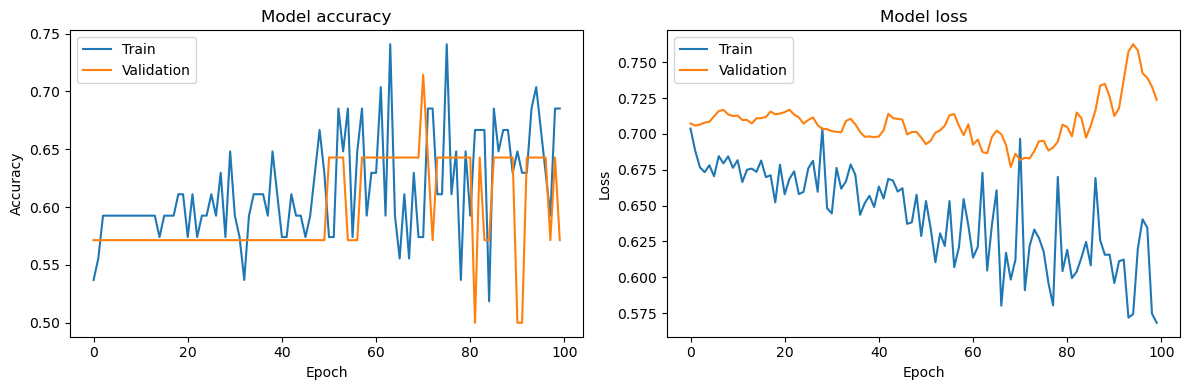

In [11]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Assume epilepsy_triplets and healthy_triplets are available
# For this example, let's create some dummy data
# epilepsy_triplets = np.random.rand(50, 3)  # 50 samples, 3 features each
# healthy_triplets = np.random.rand(35, 3)   # 35 samples, 3 features each

# Create labels
epilepsy_labels = np.ones(len(epilepsy_triplets))  # Label epilepsy as 1
healthy_labels = np.zeros(len(healthy_triplets))   # Label healthy as 0

# Combine the data
X = np.concatenate((epilepsy_triplets, healthy_triplets), axis=0)
y = np.concatenate((epilepsy_labels, healthy_labels), axis=0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=8, validation_split=0.2, verbose=1)

# Evaluate the model
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Convert predictions and true labels to 1D array for metrics calculation
y_test = y_test.flatten()
y_pred = y_pred.flatten()

# Metrics
accuracy = np.mean(y_pred == y_test)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)
print("Confusion Matrix:")
print(conf_matrix)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
